This notebook is **STRICTLY** used to create the plots in the paper.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm
from scipy.interpolate import griddata
from scipy.special import erf
from scipy.odr import ODR, Model, RealData

from astropy.coordinates import SkyCoord

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator

import getdist
from getdist import plots, MCSamples

from loess.loess_2d import loess_2d

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from src.utils.constants import *
from src.utils.functions import *
from src.utils.CosmoFunc import *

from scipy.stats import norm

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)


SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))

# Figure 1. $ϵ_\text{SDSS-LAMOST}$ vs $s_\text{avg}$

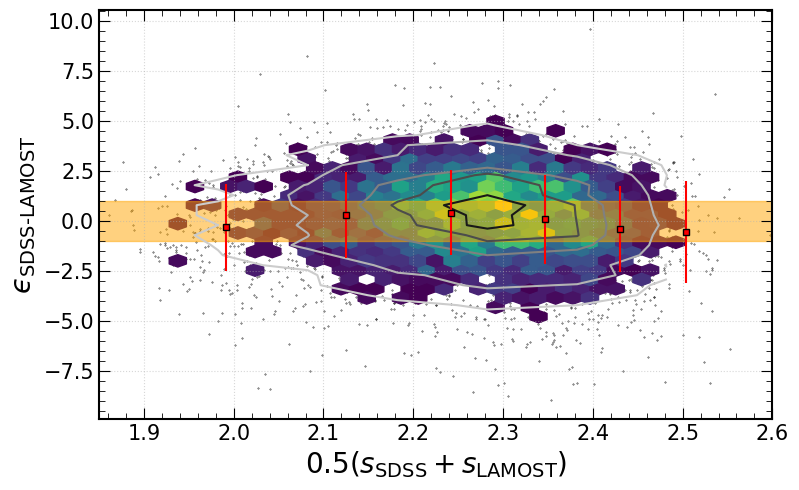

In [99]:
VELDISP_ORI_OUTPUT_FILEPATH = os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/repeat_ori.csv')

df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
df = df[~(df['s_sdss'].isna()) & ~(df['s_lamost'].isna())]

# Calculate epsilon
df['epsilon'] = (df['s_sdss'] - df['s_lamost']) / np.sqrt(df['es_sdss']**2 + df['es_lamost']**2)
df = df[np.absolute(df['epsilon']) < 10.]
# Calculate the average (to avoid correlated errors)
df['s_avg'] = 0.5 * (df['s_sdss'] + df['s_lamost'])

# Prepare the bins
S_BIN_WIDTH = 50.
# bin_list = np.log10(np.arange(10**df['s_avg'].min(), 10**df['s_avg'].max() + S_BIN_WIDTH, S_BIN_WIDTH))
bin_list = np.log10(np.array([1., 112., 150., 200., 250., 300., 500.]))
bin_label = range(1, len(bin_list))
df['s_bin'] = pd.cut(df['s_avg'], bin_list, labels=bin_label)

# Create the figure
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Create hexbin plot and bin coordinate and its corresponding value
ax.scatter(df['s_avg'], df['epsilon'], s=0.1, c='k')
h = ax.hexbin(df['s_avg'], df['epsilon'], gridsize=(40, 20), mincnt=5)
xy = h.get_offsets()
x = xy[:, 0]
y = xy[:, 1]
v = h.get_array()

xi=np.linspace(x.min(), x.max(), 25)
yi=np.linspace(y.min(), y.max(), 25)

# Create contour plot
X,Y= np.meshgrid(xi,yi)
Z = griddata((x, y), v, (X, Y), method='cubic')
# ax.contour(X, Y, Z, levels=[10, 15, 20, 22], cmap='gist_yarg', alpha=0.8)
cmap_ = plt.get_cmap("gray")
levels_plot = [(0.1, (0.1, 0.5), cmap_(0.1)), (0.25, (0.1, 0.5), cmap_(0.3)), (0.5, (0.1, 0.5), cmap_(0.5)), (0.75, (0.1, 0.5), cmap_(0.7)), (0.9, (0.1, 0.5), cmap_(0.8))]
density_contour(df['s_avg'], df['epsilon'], bins_levels_tuple_list=levels_plot, ax=ax)

# Create binned epsilon
df_grouped = df.groupby(['s_bin'], observed=False).agg(bin_count=('epsilon', 'count'), s_avg_mean=('s_avg', 'mean'), epsilon_mean=('epsilon', 'mean'), epsilon_std=('epsilon', 'std'))
df_grouped['mean_error'] = df_grouped['epsilon_std'] / np.sqrt(df_grouped['bin_count'])
ax.errorbar(x=df_grouped['s_avg_mean'], y=df_grouped['epsilon_mean'], yerr=df_grouped['epsilon_std'], marker='s', mfc='red',
         mec='k', ms=5, mew=1, ecolor='red', color='red', ls='none')

# Create horizontal line
# ax.axhline(y=0, color='k', ls='--')
# ax.axhline(y=1, color='k', ls=':')
# ax.axhline(y=-1, color='k', ls=':')
ax.fill_between(x=[1.8, 2.6], y1=[1.0, 1.0], y2=[-1.0, -1.0], alpha=0.5, color='orange')
ax.grid(ls=':', alpha=0.5)

# Labels and stuff
ax.set_xlabel(r'$0.5(s_\text{SDSS} + s_\text{LAMOST})$', fontsize=20)
ax.set_ylabel(r'$ϵ_\text{SDSS-LAMOST}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlim(1.85, 2.6)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.minorticks_on()
ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

# Save figure
fig.tight_layout()
fig.savefig('../img/final_plot/fig_1_epsilon_vs_savg.pdf', bbox_inches='tight', dpi=300)

# Figure 2. Veldisp pairwise errors before vs after

Generating comparison plot with the following inputs:
Method: lamost_only
k_6df: 1.0
k_sdss: 1.0
k_lamost: 2.638467792758444
off_6df: -0.0225179884863242
off_sdss: 0.0
off_lamost: -0.0059356239175928

Comparison between 6df and sdss before scaling. Ngal = 6541...
- Mean of ϵ is -0.562 with standard error in the mean of 0.103. Therefore it is -5.448σ away from the expected 0.
- Std of ϵ is 0.661 with standard error in the std of 0.074. Therefore it is -4.595σ away from the expected 1.
Comparison between 6df and sdss after scaling. Ngal = 6541...
- Mean of ϵ is -0.164 with standard error in the mean of 0.106. Therefore it is -1.544σ away from the expected 0.
- Std of ϵ is 0.678 with standard error in the std of 0.076. Therefore it is -4.245σ away from the expected 1.

Comparison between sdss and lamost before scaling. Ngal = 6541...
- Mean of ϵ is 0.269 with standard error in the mean of 0.027. Therefore it is 9.791σ away from the expected 0.
- Std of ϵ is 2.21 with standard error in the

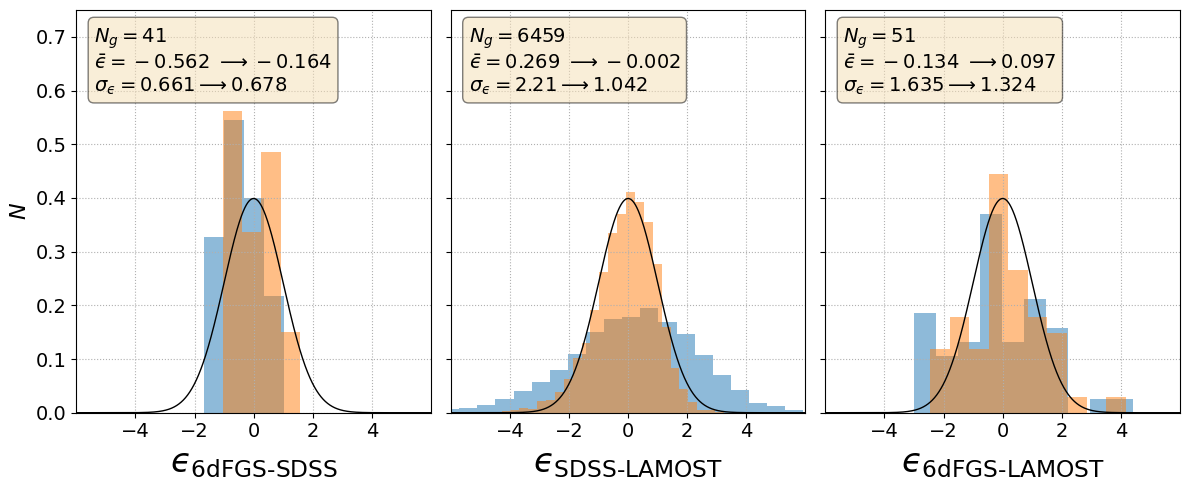

In [2]:
VELDISP_ORI_OUTPUT_FILEPATH = os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/repeat_ori.csv')

method = 'lamost_only'

off_6df, off_sdss, off_lamost = pd.read_csv('../artifacts/veldisp_calibration/totoffs.csv').loc[0].to_numpy()
k_6df, k_sdss, k_lamost = pd.read_csv(f'../artifacts/veldisp_calibration/scaling_{method}.csv').loc[0].to_numpy()

# CONSTANTS
BIN_LIST = [4, 40, 10]
XLIM_LIST = [(-6, 6), (-6, 6), (-6, 6)]
SURVEY_COMBOS = [('6df', 'sdss'), ('sdss', 'lamost'), ('6df', 'lamost')]
XLABEL_LIST = [r'$ϵ_\text{6dFGS-SDSS}$', r'$ϵ_\text{SDSS-LAMOST}$', r'$ϵ_\text{6dFGS-LAMOST}$']

print('Generating comparison plot with the following inputs:')
print(f'Method: {method}')
print(f'k_6df: {k_6df}')
print(f'k_sdss: {k_sdss}')
print(f'k_lamost: {k_lamost}')
print(f'off_6df: {off_6df}')
print(f'off_sdss: {off_sdss}')
print(f'off_lamost: {off_lamost}')
print()

df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
# off_6df = 0.
# off_sdss = 0.
# off_lamost = 0.
# Apply the offsets
df['s_6df_scaled'] = df['s_6df'] - off_6df
df['es_6df_scaled'] = df['es_6df'] * k_6df
df['s_sdss_scaled'] = df['s_sdss'] - off_sdss
df['es_sdss_scaled'] = df['es_sdss'] * k_sdss
df['s_lamost_scaled'] = df['s_lamost'] - off_lamost
df['es_lamost_scaled'] = df['es_lamost'] * k_lamost

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 5))

for i, combo in enumerate(SURVEY_COMBOS):
    survey_1, survey_2 = combo

    # Calculate original statistics
    epsilon = (df[f's_{survey_1}'] - df[f's_{survey_2}']) / np.sqrt(df[f'es_{survey_1}']**2 + df[f'es_{survey_2}']**2)
    Ngal = epsilon.notna().sum()
    # Calculate mean, std, and standard errors in them
    eps_mean = epsilon.median()
    eps_std = epsilon.std()
    eps_mean_stderr = eps_std / np.sqrt(Ngal)
    eps_std_stderr = eps_std / np.sqrt(2 * (Ngal - 1))
    mean_severity = eps_mean / eps_mean_stderr
    std_severity = (eps_std - 1.0) / eps_std_stderr

    print(f"Comparison between {survey_1} and {survey_2} before scaling. Ngal = {len(df)}...")
    print(f'- Mean of ϵ is {np.round(eps_mean, 3)} with standard error in the mean of {np.round(eps_mean_stderr, 3)}. Therefore it is {np.round(mean_severity, 3)}σ away from the expected 0.')
    print(f'- Std of ϵ is {np.round(eps_std, 3)} with standard error in the std of {np.round(eps_std_stderr, 3)}. Therefore it is {np.round(std_severity, 3)}σ away from the expected 1.')

    # Calculate statistics after scaling and offset
    epsilon_scaled = (df[f's_{survey_1}_scaled'] - df[f's_{survey_2}_scaled']) / np.sqrt(df[f'es_{survey_1}_scaled']**2 + df[f'es_{survey_2}_scaled']**2)
    Ngal_scaled = epsilon_scaled.notna().sum()
    # Calculate mean, std, and standard errors in them
    eps_scaled_mean = epsilon_scaled.median()
    eps_scaled_std = epsilon_scaled.std()
    eps_scaled_mean_stderr = eps_scaled_std / np.sqrt(Ngal_scaled)
    eps_scaled_std_stderr = eps_scaled_std / np.sqrt(2 * (Ngal_scaled - 1))
    scaled_mean_severity = eps_scaled_mean / eps_scaled_mean_stderr
    scaled_std_severity = (eps_scaled_std - 1.0) / eps_scaled_std_stderr

    print(f"Comparison between {survey_1} and {survey_2} after scaling. Ngal = {len(df)}...")
    print(f'- Mean of ϵ is {np.round(eps_scaled_mean, 3)} with standard error in the mean of {np.round(eps_scaled_mean_stderr, 3)}. Therefore it is {np.round(scaled_mean_severity, 3)}σ away from the expected 0.')
    print(f'- Std of ϵ is {np.round(eps_scaled_std, 3)} with standard error in the std of {np.round(eps_scaled_std_stderr, 3)}. Therefore it is {np.round(scaled_std_severity, 3)}σ away from the expected 1.')

    axs[i].hist(epsilon, bins=BIN_LIST[i], density=True, alpha=0.5)
    axs[i].hist(epsilon_scaled, bins=BIN_LIST[i], density=True, alpha=0.5)

    # Write the before and after statistics
    textstr = '\n'.join((
        fr'$N_g = {Ngal}$',
        r'$\bar{ϵ}=%.3f$' % eps_mean + fr' $\longrightarrow {np.round(eps_scaled_mean, 3)}$',
        fr'$\sigma_ϵ={np.round(eps_std, 3)} \longrightarrow {np.round(eps_scaled_std, 3)}$'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[i].text(-5.4, 0.72, textstr, fontsize=14,
            verticalalignment='top', bbox=props)

    # Misc
    axs[i].grid(linestyle=":")
    axs[i].set_xlim(XLIM_LIST[i])
    axs[i].set_ylim(0., 0.75)
    axs[i].set_xlabel(XLABEL_LIST[i], fontsize=24)
    axs[i].set_xticks(axs[i].get_xticks()[1:-1])
    axs[0].set_ylabel(r'$N$', fontsize=16)
    
    print()

# Plot standard normal Gaussians (target)
x = np.arange(start=-10., stop=10., step=0.0001)
y = norm.pdf(x, loc=0., scale=1.)
for ax in axs:
    ax.plot(x, y, c='k', lw=1.0)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

plt.subplots_adjust(wspace=0)

plt.tight_layout()
# fig.savefig('../img/final_plot/veldisp_comparison.pdf', bbox_inches='tight', dpi=300)

# Figure 3. Redshift, Magnitude, and FP observables distributions

6dFGS | 6136
SDSS | 4379
LAMOST | 2102


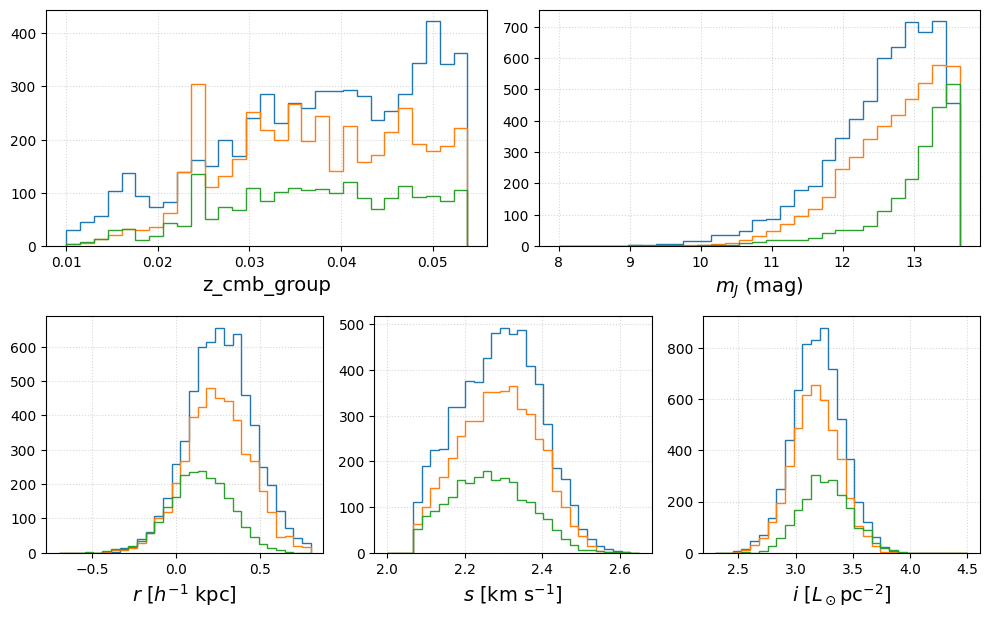

In [2]:
# Create a figure
fig = plt.figure(figsize=(10, 18))

# Create a GridSpec with 3 rows and 3 columns
gs = gridspec.GridSpec(6, 6, figure=fig)

# First row, two equal sized columns
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:])
# Second row, three equal sized columns
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# Column names and labels
cols = ['z_dist_est', 'mag_j', 'r', 's', 'i']
col_labels = ['z_cmb_group', r'$m_J$ (mag)', r'$r$ [$h^{-1}$ kpc]', r'$s$ [km s$^{-1}$]', r'$i\ [L_\odot \mathrm{pc}^{-2}]$']

# Number of bins
N_BINS = 30

# Define the bins
hist_bins = {
    "z_dist_est": np.linspace(ZMIN, ZMAX, N_BINS), # redshift bins
    "mag_j": np.linspace(MAG_LOW, MAG_HIGH, N_BINS), # magnitude bins
    "r": np.linspace(-0.7, 0.8, N_BINS), # radius bins
    "s": np.linspace(2.0, 2.65, N_BINS), # veldisp bins
    "i": np.linspace(2.3, 4.5, N_BINS) # intensity bins
}

for survey in SURVEY_LIST:
    df = pd.read_csv(f'../data/foundation/fp_sample_final/smin_setting_1/{survey.lower()}.csv')
    print(survey, '|', len(df))
    df['mag_j'] = df['j_m_ext'] - df['extinction_j']

    for i, col in enumerate(cols):
        ax = fig.axes[i]
        ax.hist(df[col], bins=hist_bins.get(col), histtype='step')
        ax.set_xlabel(col_labels[i], fontsize=14)
#         ax.set_ylabel(r'$N$', fontsize=14)
#         ax.set_yscale('log')

for ax in fig.axes:
    ax.grid(ls=':', alpha=0.5)

# Adjust layout to make it look nice
fig.tight_layout()
# fig.savefig('../img/final_plot/fig_3_fp_distributions.pdf', bbox_inches='tight', dpi=300)

In [100]:
# # Create a figure
# fig = plt.figure(figsize=(10, 18))

# # Create a GridSpec with 3 rows and 3 columns
# gs = gridspec.GridSpec(6, 6, figure=fig)

# # First row, two equal sized columns
# ax1 = fig.add_subplot(gs[0, 0:3])
# ax2 = fig.add_subplot(gs[0, 3:])
# # Second row, three equal sized columns
# ax3 = fig.add_subplot(gs[1, 0:2])
# ax4 = fig.add_subplot(gs[1, 2:4])
# ax5 = fig.add_subplot(gs[1, 4:6])

# # Column names and labels
# cols = ['z_dist_est', 'mag_j', 'r', 's', 'i']
# col_labels = ['z_cmb_group', r'$m_J$ (mag)', r'$r$ [$h^{-1}$ kpc]', r'$s$ [km s$^{-1}$]', r'$i\ [L_\odot \mathrm{pc}^{-2}]$']

# # Number of bins
# N_BINS = 30

# # Define the bins
# hist_bins = {
#     "z_dist_est": np.linspace(ZMIN, ZMAX, N_BINS), # redshift bins
#     "mag_j": np.linspace(MAG_LOW, MAG_HIGH, N_BINS), # magnitude bins
#     "r": np.linspace(-0.7, 0.8, N_BINS), # radius bins
#     "s": np.linspace(2.0, 2.65, N_BINS), # veldisp bins
#     "i": np.linspace(2.3, 4.5, N_BINS) # intensity bins
# }

# for survey in ['6dFGS', 'SDSS_LAMOST']:
#     df = pd.read_csv(f'../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv')
#     print(survey, '|', len(df))
#     df['mag_j'] = df['j_m_ext'] - df['extinction_j']

#     # # Separate NGC and SGC galaxies for LAMOST
#     # if survey.lower() == "lamost":
#     #     coords = SkyCoord(df['ra'], df['dec'], unit='deg', frame ='fk5')
#     #     coords_gal = coords.transform_to('galactic')
#     #     df['l'] = coords_gal.l.value
#     #     df['b'] = coords_gal.b.value

#     #     # Add flag
#     #     df['footprint'] = np.where(df['b'] > 0., 'NGC', 'SGC')

#     #     # Plot NGC and SGC separately
#     #     df_ngc = df[df['footprint'] == 'NGC']
#     #     df_sgc = df[df['footprint'] == 'SGC']

#     #     for i, col in enumerate(cols):
#     #         ax = fig.axes[i]
#     #         ax.hist(df_ngc[col], bins=hist_bins.get(col), histtype='step')
#     #         ax.hist(df_sgc[col], bins=hist_bins.get(col), histtype='step')
#     #         ax.set_xlabel(col_labels[i], fontsize=14)
#     #     continue

#     for i, col in enumerate(cols):
#         ax = fig.axes[i]
#         ax.hist(df[col], bins=hist_bins.get(col), histtype='step', density=True)
#         ax.set_xlabel(col_labels[i], fontsize=14)
        
# for ax in fig.axes:
#     ax.grid(ls=':', alpha=0.5)

# # Adjust layout to make it look nice
# fig.tight_layout()
# # fig.savefig('../img/final_plot/fig_3_fp_distributions.pdf', bbox_inches='tight', dpi=300)

# Figure 4. Photometric Error Model

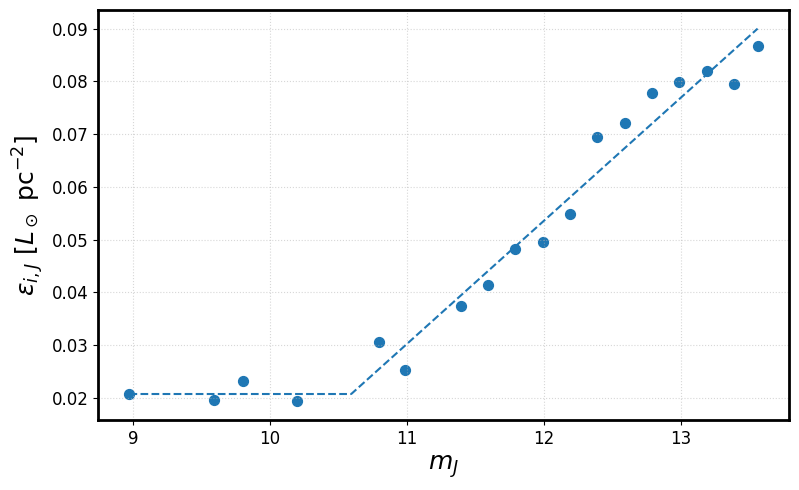

In [14]:
def piecewise_linear(x: np.ndarray, x0: float, y0: float, k: float) -> np.ndarray:
    '''
    A function that is constant at x <= x0, and linear at x > x0.
    '''
    y_pred = np.piecewise(x, [x <= x0, x > x0], [lambda x: y0, lambda x: k * (x - x0) + y0])
    return y_pred

# Load the model
popt = pd.read_csv('../artifacts/phot_error/smin_setting_1/model.csv').to_numpy()[0]

# Load the data
x_data = np.load('../artifacts/phot_error/smin_setting_1/xdata.npy')
y_data = np.load('../artifacts/phot_error/smin_setting_1/ydata.npy')

# Load trial x and y
x_trial = np.linspace(np.min(x_data), np.max(x_data), 1000)
y_trial = piecewise_linear(x_trial, *popt)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

ax.scatter(x_data, y_data, s=50)
ax.plot(x_trial, y_trial, ls='--')
ax.set_xlabel(r'$m_J$', fontsize=18)
ax.set_ylabel(r'$\epsilon_{i, J}\ [L_\odot\ \mathrm{pc}^{-2}]$', fontsize=18)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(ls=':', alpha=0.5)

fig.tight_layout()
# fig.savefig('../img/final_plot/phot_errors.pdf', bbox_inches='tight', dpi=300)

# Figure 5. FP Likelihood Cornerplot

0 6dFGS
Removed no burn in
1 SDSS
Removed no burn in
2 LAMOST
Removed no burn in
3 ALL_COMBINED
Removed no burn in


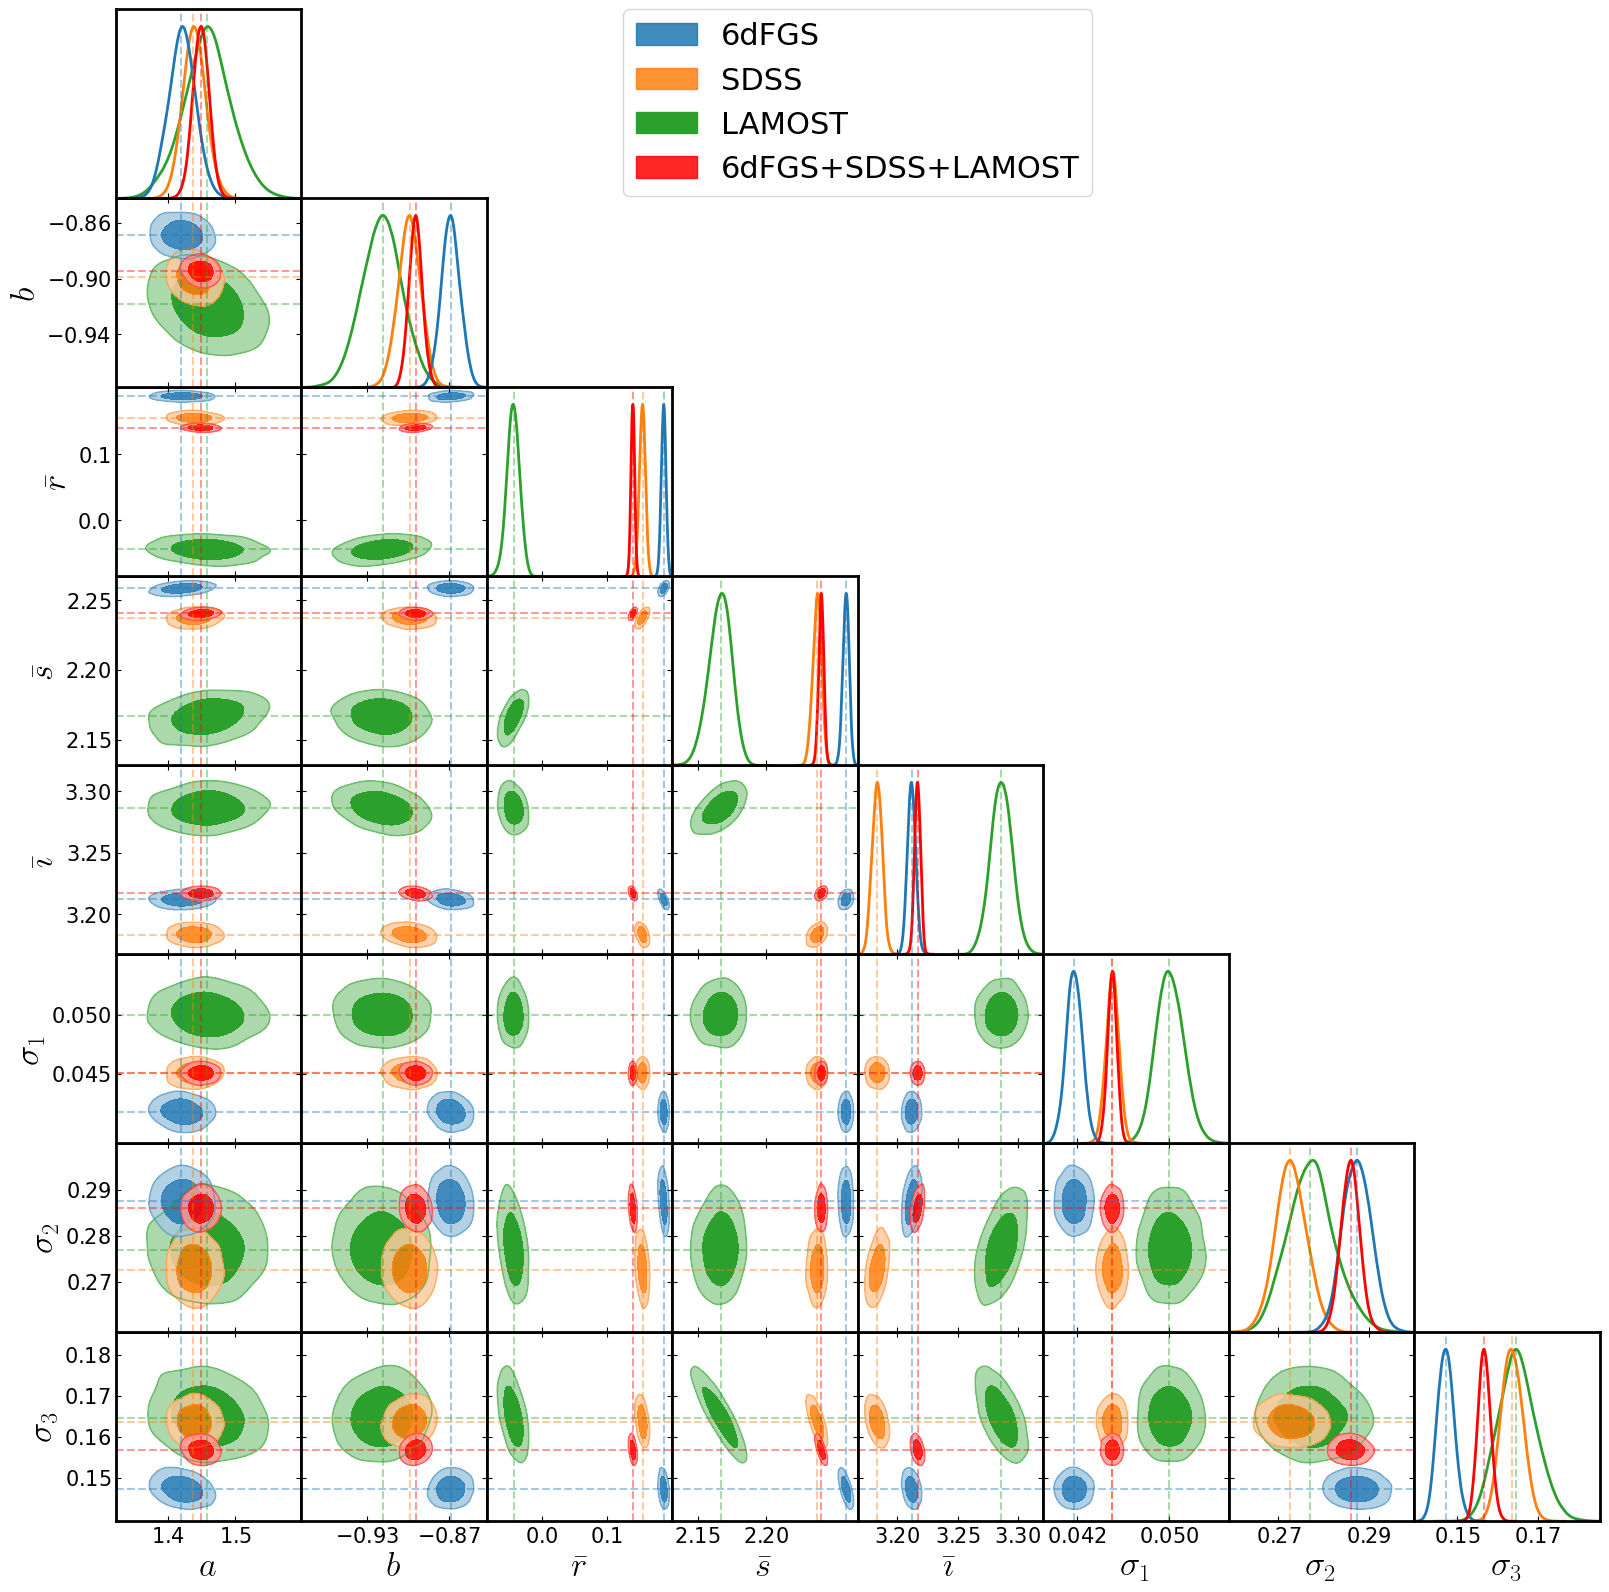

In [15]:
mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['font.family'] = 'sans-serif'

# Lower triangle: full f_n method (fp_fit_method_0)
FP_FIT_FILEPATH_METHOD_0 = os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv')

# Parameter names
names_list = [r'$a$', r'$b$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

# surveys to plot list
survey_list = ['6dFGS', 'SDSS', 'LAMOST', 'ALL_COMBINED']
survey_colours = ["C0", "C1", "C2", "red"]

mcmc_chain_list = []
best_fits_list = []
getdist_mcsample_list = []
for i, survey in enumerate(survey_list):
    print(i, survey)

    # Load the likelihood
    mcmc_chain = np.load(os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_1/fp_fit_method_0/{survey.lower()}_chain.npy'))
    mcmc_chain_list.append(mcmc_chain)

    # Load best-fit values
    best_fits = pd.read_csv(FP_FIT_FILEPATH_METHOD_0, index_col=0).loc[survey].to_numpy()
    best_fits_list.append(best_fits)

    # Create getdist object from chain
    label_ = survey
    if survey == '6dFGS_SDSS':
        label_ = '6dFGS+SDSS'
    elif survey == 'ALL_COMBINED':
        label_ = '6dFGS+SDSS+LAMOST'
    getdist_mcsample = getdist.MCSamples(samples=mcmc_chain, names=names_list, label=label_)
    getdist_mcsample_list.append(getdist_mcsample)

# Reorder to set the z_order
reorder_list = [2, 1, 0, 3]
survey_colours_reorder = [survey_colours[i] for i in reorder_list]

# Triangle plot
g = getdist.plots.get_subplot_plotter()
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 20
g.triangle_plot(roots=[getdist_mcsample_list[i] for i in reorder_list], filled=True,
                contour_lws=[2] * len(getdist_mcsample_list),
                label_order=reorder_list,
                contour_colors=survey_colours_reorder
                )

# Best-fit values
alpha_val = 0.4
ndim = 8

for k, best_fits in enumerate(best_fits_list):
    for i in range(ndim):    
        for j in range(ndim):
            if j<=i:
                ax = g.subplots[i,j]
                ax.axvline(best_fits[j], color=survey_colours[k], ls='--', alpha=alpha_val)
                ax.set_xlabel(ax.get_xlabel(), usetex=True, fontsize=25, family='sans-serif')
                ax.set_ylabel(ax.get_ylabel(), usetex=True, fontsize=25, family='sans-serif')
                ax.tick_params(axis='both', which='major', labelsize=15)

                if i != j:
                    ax.axhline(best_fits[i], color=survey_colours[k], ls='--', alpha=alpha_val)

# g.export('../img/final_plot/fig_5_fp_likelihood.pdf', dpi=300)

# Fig 6. New method vs old method slopes

0 6dFGS
Removed no burn in
1 SDSS
Removed no burn in
2 LAMOST
Removed no burn in
0 6dFGS
Removed no burn in
1 SDSS
Removed no burn in
2 LAMOST
Removed no burn in


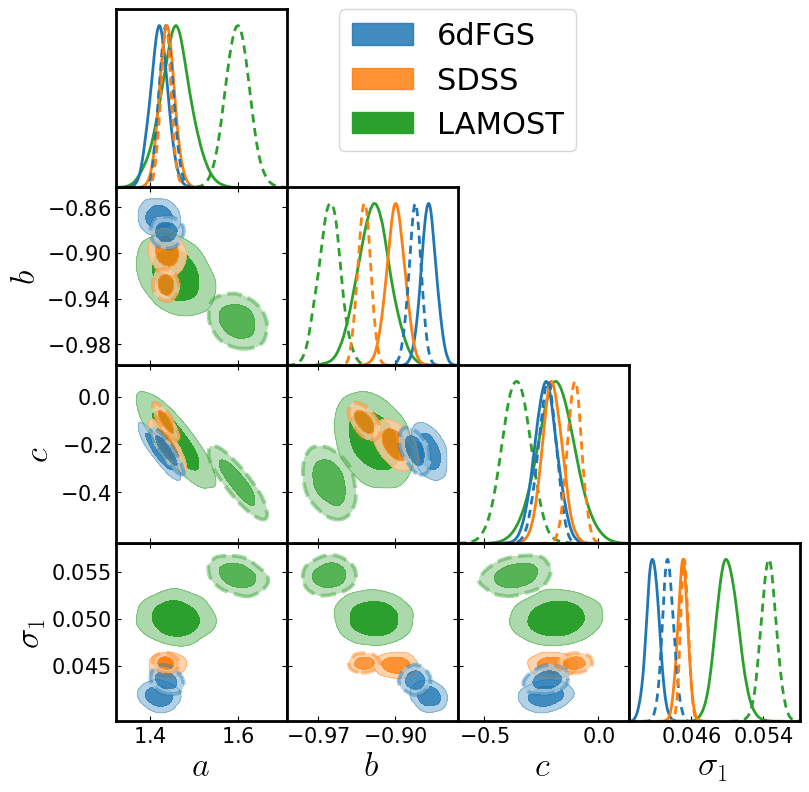

In [101]:
mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['font.family'] = 'sans-serif'

# Lower triangle: full f_n method (fp_fit_method_0)
FP_FIT_FILEPATH_METHOD_0 = os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv')

# parameter names
names_list = [r"$a$", r'$b$', r'$c$', r'$\sigma_1$']

# surveys to plot list
survey_list = ["6dFGS", "SDSS", "LAMOST"]

mcmc_chain_list = []
best_fits_list = []
getdist_mcsample_list = []
for fp_fit_method in [0, 1]:
    for i, survey in enumerate(survey_list):
        print(i, survey)

        # Load the likelihood
        mcmc_chain = np.load(os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}_chain.npy'))

        # Calculate zero-point and select slopes, zero-point, and sigma_1
        c_likelihood = (mcmc_chain[:, 2] - mcmc_chain[:, 0] * mcmc_chain[:, 3] - mcmc_chain[:, 1] * mcmc_chain[:, 4]).reshape(-1, 1)
        mcmc_chain = np.append(mcmc_chain, c_likelihood, axis=1)
        mcmc_chain = mcmc_chain[:, [0, 1, 8, 5]]
        mcmc_chain_list.append(mcmc_chain)

        # Load best-fit values
        best_fits = pd.read_csv(FP_FIT_FILEPATH_METHOD_0, index_col=0).loc[survey]
        best_fits['c'] = best_fits['rmean'] - best_fits['a'] * best_fits['smean'] - best_fits['b'] * best_fits['imean']
        best_fits = best_fits[['a', 'b', 'c', 's1']].to_numpy()
        best_fits_list.append(best_fits)

        # Create getdist object from chain
        label_ = rf'{survey} full $f_n$' if fp_fit_method == 0 else rf'{survey} partial $f_n$'
        getdist_mcsample = getdist.MCSamples(samples=mcmc_chain, names=names_list)
        getdist_mcsample_list.append(getdist_mcsample)

# Triangle plot
g = getdist.plots.get_subplot_plotter()
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 20

triangle_plot_configs = [
    {
        "root": getdist_mcsample_list[0],
        "label": "6dFGS",
        "contour_args": {"color": "C0"},
        "line_args": {"color": "C0", "ls": "-"},
        "contour_lws": 1.0
    },
    {
        "root": getdist_mcsample_list[1],
        "label": "SDSS",
        "contour_args": {"color": "C1"},
        "line_args": {"color": "C1", "ls": "-"},
        "contour_lws": 1.0
    },
    {
        "root": getdist_mcsample_list[2],
        "label": "LAMOST",
        "contour_args": {"color": "C2"},
        "line_args": {"color": "C2", "ls": "-"},
        "contour_lws": 1.0
    },
    {
        "root": getdist_mcsample_list[3],
        "label": "6dFGS",
        "contour_args": {"color": "C0", "ls": "--", "alpha": 0.8},
        "line_args": {"color": "C0", "ls": "--"},
        "contour_lws": 5.0
    },
    {
        "root": getdist_mcsample_list[4],
        "label": "SDSS",
        "contour_args": {"color": "C1", "ls": "--", "alpha": 0.8},
        "line_args": {"color": "C1", "ls": "--"},
        "contour_lws": 5.0
    },
    {
        "root": getdist_mcsample_list[5],
        "label": "LAMOST",
        "contour_args": {"color": "C2", "ls": "--", "alpha": 0.8},
        "line_args": {"color": "C2", "ls": "--"},
        "contour_lws": 5.0
    },
]

# Reorder the configs
reorder_list = [2, 5, 0, 1, 3, 4]
label_order = [reorder_list.index(value) for value in [0, 1, 2]]
reordered_triangle_plot_configs = []

for order_ in reorder_list:
    for i, config in enumerate(triangle_plot_configs):
        if order_ == i:
            reordered_triangle_plot_configs.append(config)

# List to be passed to triangle_plot
roots = [config["root"] for config in reordered_triangle_plot_configs]
legend_labels = [config["label"] for config in reordered_triangle_plot_configs]
contour_args = [config["contour_args"] for config in reordered_triangle_plot_configs]
line_args = [config["line_args"] for config in reordered_triangle_plot_configs]
contour_lws = [config["contour_lws"] for config in reordered_triangle_plot_configs]

g.triangle_plot(roots=[*roots], filled=True,
                contour_lws=contour_lws,
                line_args=line_args,
                legend_labels=legend_labels,
                contour_args=contour_args,
                diag1d_kwargs={"lws": [2.0, 2.0, 2.0, 2.0, 2.0, 2.0]},
                label_order=label_order
                )

alpha_val = 0.4
ndim = 4
for i in range(ndim):    
    for j in range(ndim):
        if (j > i):
            continue
        ax = g.subplots[i,j]
        ax.set_xlabel(ax.get_xlabel(), usetex=True, fontsize=25, family='sans-serif')
        ax.set_ylabel(ax.get_ylabel(), usetex=True, fontsize=25, family='sans-serif')
        ax.tick_params(axis='both', which='major', labelsize=15)

# g.export('../img/final_plot/fig_6_old_vs_new.pdf', dpi=300)

# Fig 7. Mock fits

Column: a
Input value: 1.4581176991292333
Difference from full f_n: 0.00077. Significance: 0.6149727788132219
Difference from partial f_n: -0.00279. Significance: 1.4164842191102804
Column: b
Input value: -0.9181588414813906
Difference from full f_n: -0.00018. Significance: 0.3868125104360113
Difference from partial f_n: 0.00199. Significance: 2.5037281059928715
Column: c
Input value: -0.18630245562650272
Difference from full f_n: -0.00134. Significance: 0.5162195352665025
Difference from partial f_n: -0.00126. Significance: 0.31775976461310185
Column: rmean
Input value: -0.0436158339897274
Difference from full f_n: 0.00044. Significance: 1.6130004820323425
Difference from partial f_n: 0.00051. Significance: 1.3497284542932149
Column: smean
Input value: 2.167199193766753
Difference from full f_n: 0.0001. Significance: 0.39959672861891177
Difference from partial f_n: 7e-05. Significance: 0.2233036695917956
Column: imean
Input value: 3.286299433183957
Difference from full f_n: -0.00036. 

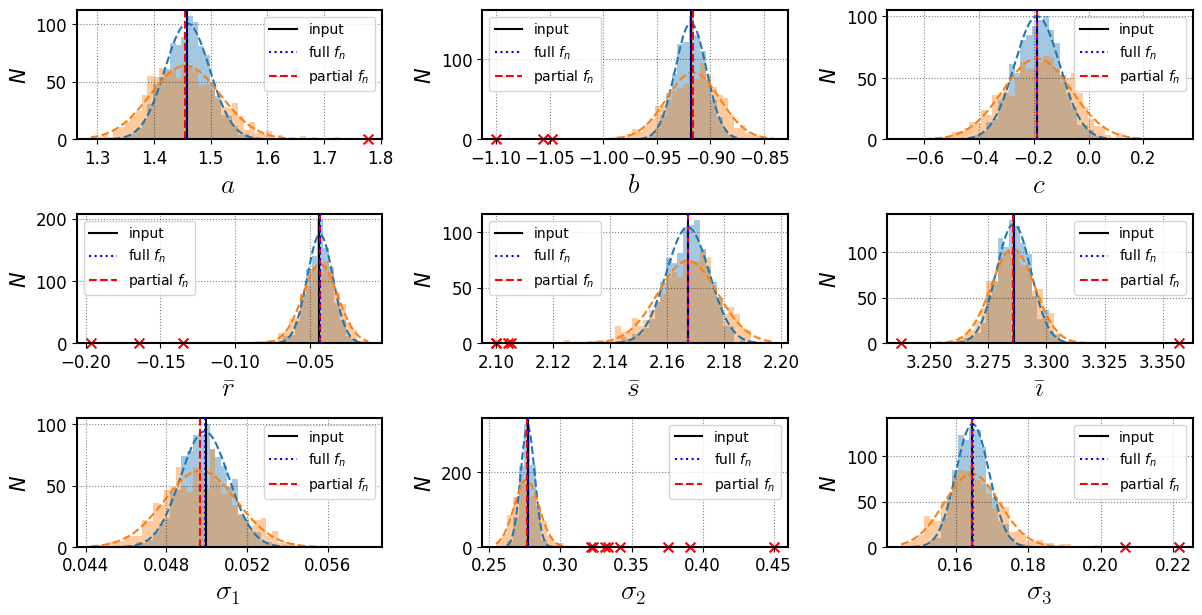

In [14]:
def remove_outliers(x, k=5.0):
    # Select inliers using MAD
    median_x = np.median(x)
    MAD_x = np.median(np.absolute(x - median_x))
    lower_ = median_x - k * MAD_x
    upper_ = median_x + k * MAD_x
    x_inliers = x[(x >= lower_) & (x <= upper_)]

    # Calculate standard deviation using the assumed inliers
    mean_ = np.mean(x_inliers)
    std_ = np.std(x_inliers)
    lower_ = mean_ - 5 * std_
    upper_ = mean_ + 5 * std_

    # Define outliers as 5 sigma away from the mean
    x_outliers = x[(x < lower_) | (x > upper_)]
    return x_inliers, x_outliers


mpl.rcParams['axes.linewidth'] = 1.5

survey = "LAMOST"

# Read mock input values
df_input_values = pd.read_csv(os.path.join(ROOT_PATH, "artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv"), index_col=[0])
df_input_values = df_input_values.rename({"s1": "sigma1", "s2": "sigma2", "s3": "sigma3"}, axis=1).loc[survey]
df_input_values["c"] = df_input_values["rmean"] - df_input_values["a"] * df_input_values["smean"] - df_input_values["b"] * df_input_values["imean"]

# Read the mock fits (using LAMOST mock generated with FP obtained from full f_n) and calculate c
df_full_fn = pd.read_csv(os.path.join(ROOT_PATH, f"artifacts/mock_fits/smin_setting_1/fp_fit_method_0/{survey.lower()}_fit_with_full_fn.csv"))
df_full_fn["c"] = df_full_fn["rmean"] - df_full_fn["a"] * df_full_fn["smean"] - df_full_fn["b"] * df_full_fn["imean"]

df_partial_fn = pd.read_csv(os.path.join(ROOT_PATH, f"artifacts/mock_fits/smin_setting_1/fp_fit_method_0/{survey.lower()}_fit_with_partial_fn_no_Sn_cut.csv"))
df_partial_fn["c"] = df_partial_fn["rmean"] - df_partial_fn["a"] * df_partial_fn["smean"] - df_partial_fn["b"] * df_partial_fn["imean"]

# Columns to plot
columns_ = ["a", "b", "c", "rmean", "smean", "imean", "sigma1", "sigma2", "sigma3"]
labels_ = [r'$a$', r'$b$', r"$c$", r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(FIGURE_WIDTH * 3 / 2, FIGURE_HEIGHT * 1.25))
for i, ax in enumerate(fig.axes):
    col = columns_[i]
    raw_full_fn = df_full_fn[col].to_numpy()
    raw_partial_fn = df_partial_fn[col].to_numpy()

    full_fn, full_fn_outliers = remove_outliers(raw_full_fn)
    partial_fn, partial_fn_outliers = remove_outliers(raw_partial_fn)

    # Create bins
    left_ = min(np.min(raw_full_fn), np.min(raw_partial_fn))
    right_ = max(np.max(raw_full_fn), np.max(raw_partial_fn))
    bins_ = np.linspace(left_, right_, 50)

    # Plot the histograms
    ax.hist(raw_full_fn, bins=bins_, density=False, alpha=0.4, color='C0')
    ax.hist(raw_partial_fn, bins=bins_, density=False, alpha=0.4, color='C1')

    # Plot the best-fitting Gaussians (and find mean and std)
    x = np.linspace(left_, right_, 1000)
    mu_full_fn, std_full_fn = norm.fit(full_fn)
    mu_partial_fn, std_partial_fn = norm.fit(partial_fn)

    y_full_fn = norm.pdf(x, mu_full_fn, std_full_fn) * (bins_[1] - bins_[0]) * len(full_fn)
    y_partial_fn = norm.pdf(x, mu_partial_fn, std_partial_fn) * (bins_[1] - bins_[0]) * len(partial_fn)

    ax.plot(x, y_full_fn, color="C0", ls="--")
    ax.plot(x, y_partial_fn, color="C1", ls="--")

    # Plot input value
    input_ = df_input_values[col]
    ax.axvline(x=input_, color="k", label="input")

    # Plot mean values of the fits
    ax.axvline(x=np.median(mu_full_fn), color="blue", ls=":", label=r"full $f_n$", zorder=100)
    ax.axvline(x=np.median(mu_partial_fn), color="red", ls="--", label=r"partial $f_n$")

    # Plot the outliers
    ax.scatter(x=full_fn_outliers, y=np.zeros(shape=len(full_fn_outliers)), marker="x", s=50, color="blue", clip_on=False)
    ax.scatter(x=partial_fn_outliers, y=np.zeros(shape=len(partial_fn_outliers)), marker="x", s=50, color="red", clip_on=False)

    # Labels
    ax.set_xlabel(labels_[i], fontsize=20, usetex=True, family="sans-serif")
    ax.set_ylabel(r"$N$", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(ls=":", color='k', alpha=0.5)
    if col=="sigma1":
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.legend()

    # Print verbose
    print("=" * 100)
    print(f"Column: {col}")
    print(f"Input value: {input_}")
    print(f"Difference from full f_n: {np.round(mu_full_fn - input_, 5)}. Significance: {np.absolute(mu_full_fn - input_) / (std_full_fn / np.sqrt(len(full_fn)))}")
    print(f"Difference from partial f_n: {np.round(mu_partial_fn - input_, 5)}. Significance: {np.absolute(mu_partial_fn - input_) / (std_partial_fn / np.sqrt(len(partial_fn)))}")

fig.tight_layout()
fig.savefig('../img/final_plot/fig_7_lamost_mocks_v1.pdf', bbox_inches='tight', dpi=300)

# Fig 8. Data vs mock for the combined sample

In [15]:
# Load FP fits
fp_fits = pd.read_csv("../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv", index_col=0).loc["ALL_COMBINED"]
fp_fits["c"] = fp_fits["rmean"] - fp_fits["a"] * fp_fits["smean"] - fp_fits["b"] * fp_fits["imean"]
a = np.round(fp_fits["a"], 3)
b = np.round(fp_fits["b"], 3)
c = np.round(fp_fits["c"], 3)

# Load the mocks
df_mock = pd.read_csv("../data/mocks/mock_galaxies/all_combined_mocks_smin_1_fp_fit_method_0.txt", delim_whitespace=True).sample(frac=0.1, random_state=42)
df_mock["r_pred"] = fp_fits["a"] * df_mock["s"] + fp_fits["b"] * df_mock["i"] + fp_fits["c"]
r_mock = df_mock["r"].to_numpy()
rpred_mock = df_mock['r_pred'].to_numpy()
s_mock = df_mock["s"].to_numpy()
i_mock = df_mock["i"].to_numpy()

# Load the data
df_data = pd.read_csv('../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_0/all_combined.csv')
df_data["r_pred"] = fp_fits["a"] * df_data["s"] + fp_fits["b"] * df_data["i"] + fp_fits["c"]
df_data["source"] = np.where(~(df_data["_6dFGS"].isna()), "6dFGS", np.where(~(df_data["objid"].isna()), "SDSS", "LAMOST"))
r_data = df_data['r'].to_numpy()
rpred_data = df_data['r_pred'].to_numpy()
s_data = df_data['s'].to_numpy()
i_data = df_data['i'].to_numpy()

/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_1751/2453878165.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=2.0, w_pad=2.0)


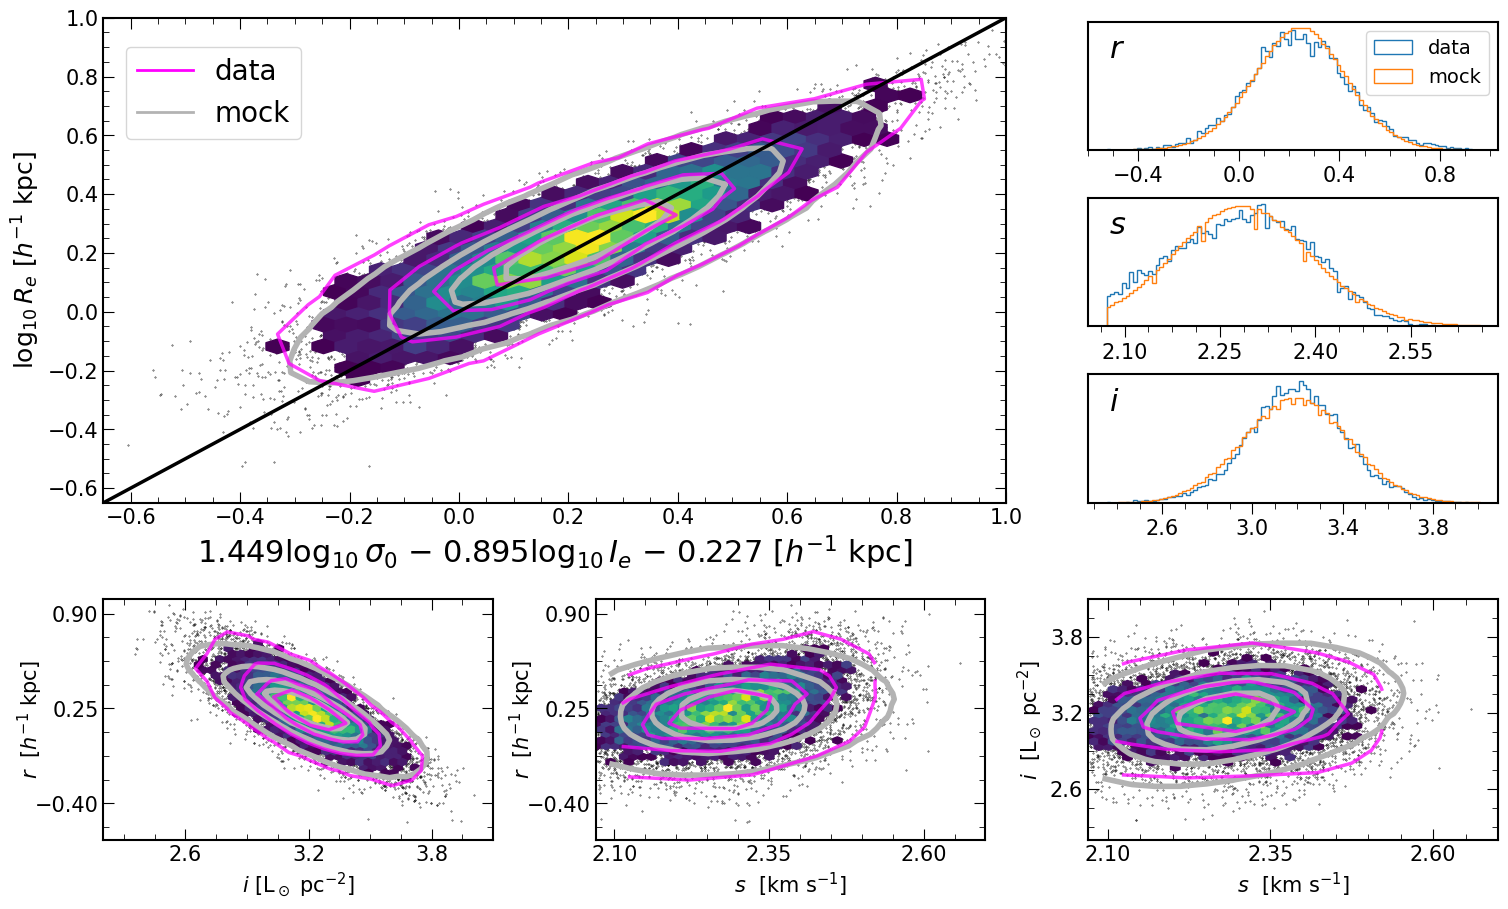

In [45]:
mpl.rcParams['axes.linewidth'] = 1.5

DATA_CMAP = 'spring'
MOCK_BINS = 100
DATA_BINS = 15
R_LIMIT = (-0.65, 1.0)
S_LIMIT = (2.07, 2.7)
I_LIMIT = (2.2, 4.1)
R_TICKS = [-0.4, 0.25, 0.9]
S_TICKS = [2.1, 2.35, 2.6]
I_TICKS = [2.6, 3.2, 3.8]

DATA_CONTOUR_COLOR = "magenta"
DATA_CONTOUR_ALPHA = 0.75
CONTOUR_LINEWIDTHS = 4.0
CONTOUR_LINESTYLES = "-"
DATA_HEXBIN_CMAP = "viridis"
HEXBIN_THRESHOLD = 10
HISTOGRAM_NBINS = 100
HISTOGRAM_NTICKS = 4

mock_cmap = plt.get_cmap("gray")
levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.7)), (0.5, (0.04, 0.04), mock_cmap(0.7)), (0.75, (0.04, 0.04), mock_cmap(0.7)), (0.95, (0.04, 0.04), mock_cmap(0.7))]
levels_plot_data = [(0.25, (0.09, 0.09), DATA_CONTOUR_COLOR), (0.5, (0.07, 0.07), DATA_CONTOUR_COLOR), (0.75, (0.08, 0.08), DATA_CONTOUR_COLOR), (0.95, (0.1, 0.1), DATA_CONTOUR_COLOR)]

# Create a figure
a_ = 10
fig = plt.figure(figsize=(a_ * 1.8, a_ / 1))
# fig = plt.figure(figsize=(a_, a_ / 1.2))

# Create a GridSpec with 3 rows and 3 columns
gs = gridspec.GridSpec(4, 3, figure=fig, height_ratios=[1, 1, 1, 3], width_ratios=[1, 1, 1], hspace=0.8)

# First axis: edge-on FP (r_obs vs r_pred)
ax1 = fig.add_subplot(gs[0:3, 0:2])

# Axis 2, 3, 4: bivariate distributions (r vs i, r vs s, i vs s)
ax2 = fig.add_subplot(gs[0, -1])
ax3 = fig.add_subplot(gs[1, -1])
ax4 = fig.add_subplot(gs[2, -1])

# Axis 5, 6, 7: histogram of r, s, i
ax5 = fig.add_subplot(gs[-1, 0])
ax6 = fig.add_subplot(gs[-1, 1])
ax7 = fig.add_subplot(gs[-1, -1])

for ax in fig.axes:
    ax.minorticks_on()

#########################################################################################################
from matplotlib.lines import Line2D

# Actual r vs predicted r (edge-on view of the FP)
scale_factor = 20
ax1.scatter(rpred_data, r_data, s=0.1, c='k')
ax1.hexbin(rpred_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

density_contour(rpred_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax1, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
density_contour(rpred_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax1, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

ax1.plot([-0.65, 1.2], [-0.65, 1.2], color="k", lw=2.5)
ax1.set_xlabel(rf'{a}{s_label} $-$ {np.absolute(b)}{i_label} $-$ {np.absolute(c)} [{r_unit}]', fontsize=22)
ax1.set_ylabel(f'{r_label} [{r_unit}]', fontsize=18)
ax1.set_xlim(R_LIMIT)
ax1.set_ylim(R_LIMIT)
ax1.tick_params(axis='both', which='major', labelsize=14)

# ################################################################################################################################################
bins_ = np.linspace(r_data.min(), r_data.max(), HISTOGRAM_NBINS)
ax2.hist(r_data, bins=bins_, density=True, histtype="step", label="data")
ax2.hist(r_mock, bins=bins_, density=True, histtype="step", label="mock")
ax2.text(0.05, 0.90, r'$r$', transform=ax2.transAxes, fontsize=22, 
         verticalalignment='top', horizontalalignment='left')
# ax2.set_xticks(np.round(np.linspace(min(R_TICKS), max(R_TICKS), 4), 2))
ax2.set_xticks([-0.4, 0.0, 0.4, 0.8])
# ax2.set_xlabel(rf"$r$ [{r_unit}]", fontsize=15)
ax2.legend(fontsize=14, loc="upper right")

bins_ = np.linspace(s_data.min(), s_data.max(), HISTOGRAM_NBINS)
ax3.hist(s_data, bins=bins_, density=True, histtype="step", label="data")
ax3.hist(s_mock, bins=bins_, density=True, histtype="step", label="mock")
ax3.text(0.05, 0.90, r'$s$', transform=ax3.transAxes, fontsize=22, 
         verticalalignment='top', horizontalalignment='left')
# ax3.set_xticks(np.round(np.linspace(min(S_TICKS), max(S_TICKS), 4), 2))
ax3.set_xticks([2.10, 2.25, 2.40, 2.55])
# ax3.set_xlabel(rf"$s$ [{s_unit}]", fontsize=15)
# ax3.legend(fontsize=15, loc="upper right")

bins_ = np.linspace(i_data.min(), i_data.max(), HISTOGRAM_NBINS)
ax4.hist(i_data, bins=bins_, density=True, histtype="step", label="data")
ax4.hist(i_mock, bins=bins_, density=True, histtype="step", label="mock")
ax4.text(0.05, 0.90, r'$i$', transform=ax4.transAxes, fontsize=22, 
         verticalalignment='top', horizontalalignment='left')
ax4.set_xticks(np.linspace(min(I_TICKS), max(I_TICKS), 4))
# ax4.set_xlabel(rf"$i$ [{i_unit}]", fontsize=15)
# ax4.legend(fontsize=14, loc="upper left")

#########################################################################################################
# r vs i
ax5.scatter(i_data, r_data, s=0.1, c='k')
ax5.hexbin(i_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

density_contour(i_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax5, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
density_contour(i_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax5, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

ax5.set_xlabel(rf'$i$ [{i_unit}]', fontsize=15)
ax5.set_ylabel(rf'$r$  [{r_unit}]', fontsize=15)
ax5.set_xlim(I_LIMIT)
ax5.set_ylim(R_LIMIT)
ax5.set_xticks(I_TICKS)
ax5.set_yticks(R_TICKS)

# r vs s
ax6.scatter(s_data, r_data, s=0.1, c='k')
ax6.hexbin(s_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

density_contour(s_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax6, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
density_contour(s_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax6, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

ax6.set_xlabel(rf'$s$  [{s_unit}]', fontsize=15)
ax6.set_ylabel(rf'$r$  [{r_unit}]', fontsize=15)
ax6.set_xlim(S_LIMIT)
ax6.set_ylim(R_LIMIT)
ax6.set_xticks(S_TICKS)
ax6.set_yticks(R_TICKS)

# s vs i
ax7.scatter(s_data, i_data, s=0.1, c='k')
ax7.hexbin(s_data, i_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

density_contour(s_mock, i_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax7, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
density_contour(s_data, i_data, bins_levels_tuple_list=levels_plot_data, ax=ax7, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

ax7.set_xlabel(rf'$s$  [{s_unit}]', fontsize=15)
ax7.set_ylabel(rf'$i$  [{i_unit}]', fontsize=15)
ax7.set_xlim(S_LIMIT)
ax7.set_ylim(I_LIMIT)
ax7.set_xticks(S_TICKS)
ax7.set_yticks(I_TICKS)

legend_elements = [
    Line2D([0], [0], color='magenta', lw=2, label='data'),
    Line2D([0], [0], color=mock_cmap(0.7), lw=2, label='mock')
    ]
ax1.legend(handles=legend_elements, loc=(0.025, 0.75), fontsize=20)

for ax in [ax2, ax3, ax4]:
    ax.set_yticks([])
    ax.tick_params(left=False)

for ax in fig.axes:
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)
    # ax.grid(ls=":", c="k", alpha=0.5)

# Change the sizes of ax2, ax3, and ax4 (the histograms) and configure the ticks
for ax in [ax2, ax3, ax4]:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width , box.height * 1.6])
    ax.tick_params(axis='both', which='both', labelsize=15, direction="out")
    minor_locator = AutoMinorLocator(4)
    ax.xaxis.set_minor_locator(minor_locator)

# Change the size of ax1 manually
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width , box.height * 1.12])

# Change the sizes of ax6 and ax7 manually
for ax in [ax5, ax6]:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.95 , box.height])
    ax.yaxis.set_label_coords(-0.15, 0.5, transform=ax.transAxes)

# Add top and right ticks for ax1, ax5, ax6, ax7
for ax in [ax1, ax5, ax6, ax7]:
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 

fig.tight_layout(h_pad=2.0, w_pad=2.0)

fig.savefig('../img/final_plot/fig_8_mock_vs_data_contour_v4.pdf', bbox_inches='tight', dpi=300)

In [229]:
# mpl.rcParams['axes.linewidth'] = 1.5

# DATA_CMAP = 'spring'
# MOCK_BINS = 100
# DATA_BINS = 15
# R_LIMIT = (-0.65, 1.0)
# S_LIMIT = (2.07, 2.7)
# I_LIMIT = (2.2, 4.1)
# R_TICKS = [-0.25, 0.25, 0.75]
# S_TICKS = [2.1, 2.35, 2.6]
# I_TICKS = [2.6, 3.2, 3.8]

# DATA_CONTOUR_COLOR = "magenta"
# DATA_CONTOUR_ALPHA = 0.75
# CONTOUR_LINEWIDTHS = 4.0
# CONTOUR_LINESTYLES = "-"
# DATA_HEXBIN_CMAP = "viridis"
# HEXBIN_THRESHOLD = 10
# HISTOGRAM_NBINS = 100

# r_label = r'$\log_{10}R_e$'
# r_unit = r'$h^{-1}$ kpc'
# s_label = r'$\log_{10}\sigma_0$'
# s_unit = r'$\mathrm{km}\ \mathrm{s}^{-1}$'
# i_label = r'$\log_{10}I_e$'
# i_unit = r'$\mathrm{L}_\odot\ \mathrm{pc}^{-2}$'

# mock_cmap = plt.get_cmap("gray")
# levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.1)), (0.5, (0.04, 0.04), mock_cmap(0.3)), (0.75, (0.04, 0.04), mock_cmap(0.6)), (0.95, (0.04, 0.04), mock_cmap(0.8))]
# levels_plot_data = [(0.25, (0.09, 0.09), DATA_CONTOUR_COLOR), (0.5, (0.07, 0.07), DATA_CONTOUR_COLOR), (0.75, (0.08, 0.08), DATA_CONTOUR_COLOR), (0.95, (0.1, 0.1), DATA_CONTOUR_COLOR)]

# # Create a figure
# a_ = 10
# fig = plt.figure(figsize=(a_ * 1.608, a_ / (4 / 3)))
# # fig = plt.figure(figsize=(a_, a_ / 1.2))

# # Create a GridSpec with 3 rows and 3 columns
# gs = gridspec.GridSpec(4, 3, figure=fig, height_ratios=[2, 1, 1, 1], width_ratios=[1, 1, 1], hspace=0.6, top=0.95, bottom=0.05,)

# # First axis: edge-on FP (r_obs vs r_pred)
# ax1 = fig.add_subplot(gs[1:, 0:2])

# ax5 = fig.add_subplot(gs[0, 0])
# ax6 = fig.add_subplot(gs[0, 1])
# ax7 = fig.add_subplot(gs[0, 2])

# ax2 = fig.add_subplot(gs[1, -1])
# ax3 = fig.add_subplot(gs[2, -1])
# ax4 = fig.add_subplot(gs[3, -1])

# # for ax in [ax5, ax6, ax7]:
# #     ax.set_aspect('equal')

# #########################################################################################################
# # Actual r vs predicted r (edge-on view of the FP)
# scale_factor = 20
# ax1.scatter(rpred_data, r_data, s=0.1, c='k')
# ax1.hexbin(rpred_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

# density_contour(rpred_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax1, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(rpred_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax1, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

# ax1.plot([-0.65, 1.2], [-0.65, 1.2], color="k", lw=2.5)
# ax1.set_xlabel(rf'{a}{s_label} $-$ {np.absolute(b)}{i_label} $-$ {np.absolute(c)} [{r_unit}]', fontsize=18)
# ax1.set_ylabel(f'{r_label} [{r_unit}]', fontsize=18)
# ax1.set_xlim(R_LIMIT)
# ax1.set_ylim(R_LIMIT)
# # ax1.tick_params(axis='both', which='major', labelsize=12)


# # ################################################################################################################################################
# bins_ = np.linspace(r_data.min(), r_data.max(), HISTOGRAM_NBINS)
# ax2.hist(r_data, bins=bins_, density=True, histtype="step")
# ax2.hist(r_mock, bins=bins_, density=True, histtype="step")
# ax2.text(0.05, 0.95, r'$r$', transform=ax2.transAxes, fontsize=18, 
#          verticalalignment='top', horizontalalignment='left')
# ax2.set_xticks(R_TICKS)

# bins_ = np.linspace(s_data.min(), s_data.max(), HISTOGRAM_NBINS)
# ax3.hist(s_data, bins=bins_, density=True, histtype="step")
# ax3.hist(s_mock, bins=bins_, density=True, histtype="step")
# ax3.text(0.05, 0.95, r'$s$', transform=ax3.transAxes, fontsize=18, 
#          verticalalignment='top', horizontalalignment='left')
# ax3.set_xticks(S_TICKS)

# bins_ = np.linspace(i_data.min(), i_data.max(), HISTOGRAM_NBINS)
# ax4.hist(i_data, bins=bins_, density=True, histtype="step")
# ax4.hist(i_mock, bins=bins_, density=True, histtype="step")
# ax4.text(0.05, 0.95, r'$i$', transform=ax4.transAxes, fontsize=18, 
#          verticalalignment='top', horizontalalignment='left')
# ax4.set_xticks(I_TICKS)

# #########################################################################################################
# # r vs i
# ax5.scatter(i_data, r_data, s=0.1, c='k')
# ax5.hexbin(i_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

# density_contour(i_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax5, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(i_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax5, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

# ax5.set_xlabel(rf'$i$ [{i_unit}]', fontsize=14)
# ax5.set_ylabel(rf'$r$  [{r_unit}]', fontsize=14)
# ax5.set_xlim(I_LIMIT)
# ax5.set_ylim(R_LIMIT)
# ax5.set_xticks(I_TICKS)
# ax5.set_yticks(R_TICKS)

# # r vs s
# ax6.scatter(s_data, r_data, s=0.1, c='k')
# ax6.hexbin(s_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

# density_contour(s_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax6, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax6, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

# ax6.set_xlabel(rf'$s$  [{s_unit}]', fontsize=14)
# ax6.set_ylabel(rf'$r$  [{r_unit}]', fontsize=14)
# ax6.set_xlim(S_LIMIT)
# ax6.set_ylim(R_LIMIT)
# ax6.set_xticks(S_TICKS)
# ax6.set_yticks(R_TICKS)

# # s vs i
# ax7.scatter(s_data, i_data, s=0.1, c='k')
# ax7.hexbin(s_data, i_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap=DATA_HEXBIN_CMAP)

# density_contour(s_mock, i_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax7, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, i_data, bins_levels_tuple_list=levels_plot_data, ax=ax7, linewidths=2.5, alpha=DATA_CONTOUR_ALPHA)

# ax7.set_xlabel(rf'$s$  [{s_unit}]', fontsize=14)
# ax7.set_ylabel(rf'$i$  [{i_unit}]', fontsize=14)
# ax7.set_xlim(S_LIMIT)
# ax7.set_ylim(I_LIMIT)
# ax7.set_xticks(S_TICKS)
# ax7.set_yticks(I_TICKS)

# for ax in [ax2, ax3, ax4]:
#     ax.set_yticks([])
#     ax.tick_params(left=False)

# for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
#     ax.tick_params(axis='both', which='major', labelsize=13)

# fig.tight_layout()
# # fig.savefig('../img/final_plot/fig_8_mock_vs_data_contour_v4.pdf', bbox_inches='tight', dpi=300)

In [122]:
# DATA_CMAP = 'spring'
# MOCK_BINS = 100
# DATA_BINS = 15
# R_LIMIT = (-0.65, 1.0)
# S_LIMIT = (2.05, 2.8)
# I_LIMIT = (2.2, 4.1)
# CONTOUR_LINEWIDTHS = 4.0
# CONTOUR_LINESTYLES = "-"

# r_label = r'$\log_{10}R_e$'
# r_unit = r'$h^{-1}$ kpc'
# s_label = r'$\log_{10}\sigma_0$'
# s_unit = r'$\mathrm{km}\ \mathrm{s}^{-1}$'
# i_label = r'$\log_{10}I_e$'
# i_unit = r'$\mathrm{L}_\odot\ \mathrm{pc}^{-2}$'

# # Create a figure
# fig = plt.figure(figsize=(24 // 1.5, 15 // 1.5))

# # Create a GridSpec with 3 rows and 3 columns
# gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[2, 1])

# # First row a single column
# ax1 = fig.add_subplot(gs[0, :])
# # Second row, three equal sized columns
# ax2 = fig.add_subplot(gs[1, 0])
# ax3 = fig.add_subplot(gs[1, 1])
# ax4 = fig.add_subplot(gs[1, 2])

# # Actual r vs predicted r (edge-on view of the FP)
# scale_factor = 20
# ax1.scatter(rpred_data, r_data, s=0.1, c='k')
# ax1.hexbin(rpred_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# mock_cmap = plt.get_cmap("gray")
# levels_plot = [(0.25, (0.04, 0.04), mock_cmap(0.1)), (0.5, (0.04, 0.04), mock_cmap(0.3)), (0.75, (0.04, 0.04), mock_cmap(0.6)), (0.95, (0.04, 0.04), mock_cmap(0.8))]
# density_contour(rpred_mock, r_mock, bins_levels_tuple_list=levels_plot, ax=ax1, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# levels_plot = [(0.25, (0.05, 0.05), "magenta"), (0.5, (0.07, 0.07), "magenta"), (0.75, (0.08, 0.08), "magenta"), (0.95, (0.1, 0.1), "magenta")]
# density_contour(rpred_data, r_data, bins_levels_tuple_list=levels_plot, ax=ax1, linewidths=2.5, alpha=0.6)

# # r vs i
# density_contour(i_mock, r_mock, MOCK_BINS, ax=ax2, colors="k", linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(i_data, r_data, DATA_BINS, ax=ax2, cmap=DATA_CMAP, linewidths=2.5)
# for cat in ["6dFGS", "SDSS", "LAMOST"]:
#     df_ = df_data[df_data["source"] == cat]
#     ax2.scatter(df_["i"], df_["r"], s=5, label=cat)
# ax2.legend(fontsize=15)
# ax2.set_xlabel(rf'$i$ [{i_unit}]', fontsize=14)
# ax2.set_ylabel(rf'$r$ [{r_unit}]', fontsize=14)
# ax2.set_xlim(I_LIMIT)
# ax2.set_ylim(R_LIMIT)

# # r vs s
# density_contour(s_mock, r_mock, MOCK_BINS, ax=ax3, colors="k", linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, r_data, DATA_BINS, ax=ax3, cmap=DATA_CMAP, linewidths=2.5)
# for cat in ["6dFGS", "SDSS", "LAMOST"]:
#     df_ = df_data[df_data["source"] == cat]
#     ax3.scatter(df_["s"], df_["r"], s=5, label=cat)
# ax3.legend(fontsize=15)
# ax3.set_xlabel(rf'$s$ [{s_unit}]', fontsize=14)
# ax3.set_ylabel(rf'$r$ [{r_unit}]', fontsize=14)
# ax3.set_xlim(S_LIMIT)
# ax3.set_ylim(R_LIMIT)

# # s vs i
# density_contour(s_mock, i_mock, MOCK_BINS, ax=ax4, colors="k", linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, i_data, DATA_BINS, ax=ax4, cmap=DATA_CMAP, linewidths=2.5)
# for cat in ["6dFGS", "SDSS", "LAMOST"]:
#     df_ = df_data[df_data["source"] == cat]
#     ax4.scatter(df_["s"], df_["i"], s=5, label=cat)
# ax4.legend(fontsize=15)
# ax4.set_xlabel(rf'$s$ [{s_unit}]', fontsize=14)
# ax4.set_ylabel(rf'$i$ [{i_unit}]', fontsize=14)
# ax4.set_xlim(S_LIMIT)
# ax4.set_ylim(I_LIMIT)

# # Shared settings
# for i, ax in enumerate(fig.axes):
#     ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.grid(c="k", alpha=0.5, ls=":")

#     if i == 0:
#         ax.legend(scatterpoints=1, markerscale=5, loc='best', fontsize=20)
#         ax.set_xlabel(ax.get_xlabel(), fontsize=20)
#         ax.set_ylabel(ax.get_ylabel(), fontsize=20)
#     else:
#         ax.legend(scatterpoints=1, markerscale=5, loc='best', fontsize=12)
#         ax.set_xlabel(ax.get_xlabel(), fontsize=15)
#         ax.set_ylabel(ax.get_ylabel(), fontsize=15)
        

# fig.tight_layout()
# # fig.savefig('../img/final_plot/fig_8_mock_vs_data_contour.pdf', bbox_inches='tight', dpi=300)

In [136]:
# mpl.rcParams['axes.linewidth'] = 1.2

# DATA_CMAP = 'spring'
# MOCK_BINS = 100
# DATA_BINS = 15
# R_LIMIT = (-0.65, 1.0)
# S_LIMIT = (2.05, 2.8)
# I_LIMIT = (2.2, 4.1)
# CONTOUR_LINEWIDTHS = 4.0
# CONTOUR_LINESTYLES = "-"
# HEXBIN_THRESHOLD = 10

# r_label = r'$\log_{10}R_e$'
# r_unit = r'$h^{-1}$ kpc'
# s_label = r'$\log_{10}\sigma_0$'
# s_unit = r'$\mathrm{km}\ \mathrm{s}^{-1}$'
# i_label = r'$\log_{10}I_e$'
# i_unit = r'$\mathrm{L}_\odot\ \mathrm{pc}^{-2}$'

# # Create a figure
# fig = plt.figure(figsize=(15, 15 // 2.5))

# # Create a GridSpec with 3 rows and 3 columns
# gs = gridspec.GridSpec(2, 5, figure=fig)

# # First axis: edge-on FP (r_obs vs r_pred)
# ax1 = fig.add_subplot(gs[:, 0:2])

# # Axis 2, 3, 4: bivariate distributions (r vs i, r vs s, i vs s)
# ax2 = fig.add_subplot(gs[0, 2])
# ax3 = fig.add_subplot(gs[0, 3])
# ax4 = fig.add_subplot(gs[0, 4])

# # Axis 5, 6, 7: histogram of r, s, i
# ax5 = fig.add_subplot(gs[1, 2])
# ax6 = fig.add_subplot(gs[1, 3])
# ax7 = fig.add_subplot(gs[1, 4])


# #########################################################################################################
# # Actual r vs predicted r (edge-on view of the FP)
# scale_factor = 20
# ax1.scatter(rpred_data, r_data, s=0.1, c='k')
# ax1.hexbin(rpred_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# mock_cmap = plt.get_cmap("gray")
# levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.1)), (0.5, (0.04, 0.04), mock_cmap(0.3)), (0.75, (0.04, 0.04), mock_cmap(0.6)), (0.95, (0.04, 0.04), mock_cmap(0.8))]
# density_contour(rpred_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax1, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# levels_plot_data = [(0.25, (0.05, 0.05), "magenta"), (0.5, (0.07, 0.07), "magenta"), (0.75, (0.08, 0.08), "magenta"), (0.95, (0.1, 0.1), "magenta")]
# density_contour(rpred_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax1, linewidths=2.5, alpha=0.6)

# ax1.plot([-0.65, 1.2], [-0.65, 1.2], color="k", lw=2.5)
# ax1.set_xlabel(rf'{a}{s_label} $-$ {np.absolute(b)}{i_label} $-$ {np.absolute(c)} [{r_unit}]', fontsize=14)
# ax1.set_ylabel(f'{r_label} [{r_unit}]', fontsize=18)
# ax1.set_xlim(R_LIMIT)
# ax1.set_ylim(R_LIMIT)
# ax1.tick_params(axis='both', which='major', labelsize=12)

# #########################################################################################################
# # r vs i
# ax2.scatter(i_data, r_data, s=0.1, c='k')
# ax2.hexbin(i_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# density_contour(i_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax2, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(i_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax2, linewidths=2.5, alpha=0.6)

# ax2.set_xlabel(r'$i$', fontsize=12)
# ax2.set_ylabel(r'$r$', fontsize=12)
# ax2.set_xlim(I_LIMIT)
# ax2.set_ylim(R_LIMIT)
# # ax2.tick_params(direction='in',  # Make ticks point inward
# #                 bottom=True,     # Enable bottom ticks
# #                 top=False,       # Disable top ticks
# #                 left=True,      # Disable left ticks
# #                 right=False)

# # r vs s
# ax3.scatter(s_data, r_data, s=0.1, c='k')
# ax3.hexbin(s_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# density_contour(s_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax3, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax3, linewidths=2.5, alpha=0.6)

# ax3.set_xlabel(r'$s$', fontsize=12)
# ax3.set_ylabel(r'$r$', fontsize=12)
# ax3.set_xlim(S_LIMIT)
# ax3.set_ylim(R_LIMIT)
# # ax3.tick_params(axis='both', direction='in',  # Ticks inward
# #                 bottom=True, top=False,       # Enable bottom ticks only
# #                 left=False, right=True,       # Enable right ticks only
# #                 length=6, width=1,            # Adjust tick length and width
# #                 pad=-10)                      # Move tick labels inside

# # Ensure tick labels are visible for the correct axes
# ax3.tick_params(labelbottom=True, labelright=True,  # Show labels on bottom and right
#                 labeltop=False, labelleft=False)

# # s vs i
# ax4.scatter(s_data, i_data, s=0.1, c='k')
# ax4.hexbin(s_data, i_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# density_contour(s_mock, i_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax4, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, i_data, bins_levels_tuple_list=levels_plot_data, ax=ax4, linewidths=2.5, alpha=0.6)

# # density_contour(s_mock, i_mock, MOCK_BINS, ax=ax4, colors="k", linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# # density_contour(s_data, i_data, DATA_BINS, ax=ax4, cmap=DATA_CMAP, linewidths=2.5)

# ax4.set_xlabel(r'$s$', fontsize=14)
# ax4.set_ylabel(r'$i$', fontsize=14)
# ax4.set_xlim(S_LIMIT)
# ax4.set_ylim(I_LIMIT)

# # ################################################################################################################################################
# bins_ = np.linspace(r_data.min(), r_data.max(), 20)
# ax5.hist(r_data, bins=bins_, density=True, histtype="step")
# ax5.hist(r_mock, bins=bins_, density=True, histtype="step")
# ax5.set_xlabel(rf'$r$ [{r_unit}]', fontsize=14)

# bins_ = np.linspace(s_data.min(), s_data.max(), 20)
# ax6.hist(s_data, bins=bins_, density=True, histtype="step")
# ax6.hist(s_mock, bins=bins_, density=True, histtype="step")
# ax6.set_xlabel(rf'$s$ [{s_unit}]', fontsize=14)

# bins_ = np.linspace(i_data.min(), i_data.max(), 20)
# ax7.hist(i_data, bins=bins_, density=True, histtype="step")
# ax7.hist(i_mock, bins=bins_, density=True, histtype="step")
# ax7.set_xlabel(rf'$i$ [{i_unit}]', fontsize=14)

# # # Shared settings
# # for i, ax in enumerate(fig.axes):
# #     ax.tick_params(axis='both', which='major', labelsize=15)
# #     ax.grid(c="k", alpha=0.5, ls=":")

# #     if i == 0:
# #         ax.set_xlabel(ax.get_xlabel(), fontsize=15)
# #         ax.set_ylabel(ax.get_ylabel(), fontsize=15)
# #     else:
# #         ax.legend(scatterpoints=1, markerscale=5, loc='best', fontsize=12)
# #         ax.set_xlabel(ax.get_xlabel(), fontsize=15)
# #         ax.set_ylabel(ax.get_ylabel(), fontsize=15)

# for ax in [ax2, ax3, ax4, ax5, ax6, ax7]:
#     ax.set_yticks([])
#     ax.tick_params(left=False)

# fig.tight_layout()
# fig.savefig('../img/final_plot/fig_8_mock_vs_data_contour_v2.pdf', bbox_inches='tight', dpi=300)

In [137]:
# mpl.rcParams['axes.linewidth'] = 1.2

# DATA_CMAP = 'spring'
# MOCK_BINS = 100
# DATA_BINS = 15
# R_LIMIT = (-0.65, 1.0)
# S_LIMIT = (2.05, 2.8)
# I_LIMIT = (2.2, 4.1)
# CONTOUR_LINEWIDTHS = 4.0
# CONTOUR_LINESTYLES = "-"
# HEXBIN_THRESHOLD = 10

# r_label = r'$\log_{10}R_e$'
# r_unit = r'$h^{-1}$ kpc'
# s_label = r'$\log_{10}\sigma_0$'
# s_unit = r'$\mathrm{km}\ \mathrm{s}^{-1}$'
# i_label = r'$\log_{10}I_e$'
# i_unit = r'$\mathrm{L}_\odot\ \mathrm{pc}^{-2}$'

# # Create a figure
# fig = plt.figure(figsize=(15, 15 // 2.5))

# # Create a GridSpec with 3 rows and 3 columns
# gs = gridspec.GridSpec(2, 5, figure=fig)

# # First axis: edge-on FP (r_obs vs r_pred)
# ax1 = fig.add_subplot(gs[:, 0:2])

# # Axis 2, 3, 4: bivariate distributions (r vs i, r vs s, i vs s)
# ax2 = fig.add_subplot(gs[0, 2])
# ax3 = fig.add_subplot(gs[0, 3])
# ax4 = fig.add_subplot(gs[0, 4])

# # Axis 5, 6, 7: histogram of r, s, i
# ax5 = fig.add_subplot(gs[1, 2])
# ax6 = fig.add_subplot(gs[1, 3])
# ax7 = fig.add_subplot(gs[1, 4])


# #########################################################################################################
# # Actual r vs predicted r (edge-on view of the FP)
# scale_factor = 20
# ax1.scatter(rpred_data, r_data, s=0.1, c='k')
# ax1.hexbin(rpred_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# mock_cmap = plt.get_cmap("gray")
# levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.1)), (0.5, (0.04, 0.04), mock_cmap(0.3)), (0.75, (0.04, 0.04), mock_cmap(0.6)), (0.95, (0.04, 0.04), mock_cmap(0.8))]
# density_contour(rpred_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax1, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# levels_plot_data = [(0.25, (0.05, 0.05), "magenta"), (0.5, (0.07, 0.07), "magenta"), (0.75, (0.08, 0.08), "magenta"), (0.95, (0.1, 0.1), "magenta")]
# density_contour(rpred_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax1, linewidths=2.5, alpha=0.6)

# ax1.plot([-0.65, 1.2], [-0.65, 1.2], color="k", lw=2.5)
# ax1.set_xlabel(rf'{a}{s_label} $-$ {np.absolute(b)}{i_label} $-$ {np.absolute(c)} [{r_unit}]', fontsize=14)
# ax1.set_ylabel(f'{r_label} [{r_unit}]', fontsize=18)
# ax1.set_xlim(R_LIMIT)
# ax1.set_ylim(R_LIMIT)
# ax1.tick_params(axis='both', which='major', labelsize=12)

# #########################################################################################################
# # r vs i
# ax2.scatter(i_data, r_data, s=0.1, c='k')
# ax2.hexbin(i_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# density_contour(i_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax2, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(i_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax2, linewidths=2.5, alpha=0.6)

# ax2.set_xlabel(r'$i$', fontsize=12)
# ax2.set_ylabel(r'$r$', fontsize=12)
# ax2.set_xlim(I_LIMIT)
# ax2.set_ylim(R_LIMIT)
# # ax2.tick_params(direction='in',  # Make ticks point inward
# #                 bottom=True,     # Enable bottom ticks
# #                 top=False,       # Disable top ticks
# #                 left=True,      # Disable left ticks
# #                 right=False)

# # r vs s
# ax3.scatter(s_data, r_data, s=0.1, c='k')
# ax3.hexbin(s_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# density_contour(s_mock, r_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax3, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, r_data, bins_levels_tuple_list=levels_plot_data, ax=ax3, linewidths=2.5, alpha=0.6)

# ax3.set_xlabel(r'$s$', fontsize=12)
# ax3.set_ylabel(r'$r$', fontsize=12)
# ax3.set_xlim(S_LIMIT)
# ax3.set_ylim(R_LIMIT)
# # ax3.tick_params(axis='both', direction='in',  # Ticks inward
# #                 bottom=True, top=False,       # Enable bottom ticks only
# #                 left=False, right=True,       # Enable right ticks only
# #                 length=6, width=1,            # Adjust tick length and width
# #                 pad=-10)                      # Move tick labels inside

# # Ensure tick labels are visible for the correct axes
# ax3.tick_params(labelbottom=True, labelright=True,  # Show labels on bottom and right
#                 labeltop=False, labelleft=False)

# # s vs i
# ax4.scatter(s_data, i_data, s=0.1, c='k')
# ax4.hexbin(s_data, i_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# density_contour(s_mock, i_mock, bins_levels_tuple_list=levels_plot_mock, ax=ax4, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# density_contour(s_data, i_data, bins_levels_tuple_list=levels_plot_data, ax=ax4, linewidths=2.5, alpha=0.6)

# # density_contour(s_mock, i_mock, MOCK_BINS, ax=ax4, colors="k", linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# # density_contour(s_data, i_data, DATA_BINS, ax=ax4, cmap=DATA_CMAP, linewidths=2.5)

# ax4.set_xlabel(r'$s$', fontsize=14)
# ax4.set_ylabel(r'$i$', fontsize=14)
# ax4.set_xlim(S_LIMIT)
# ax4.set_ylim(I_LIMIT)

# # ################################################################################################################################################
# bins_ = np.linspace(r_data.min(), r_data.max(), 20)
# ax5.hist(r_data, bins=bins_, density=True, histtype="step")
# ax5.hist(r_mock, bins=bins_, density=True, histtype="step")
# ax5.set_xlabel(rf'$r$ [{r_unit}]', fontsize=14)

# bins_ = np.linspace(s_data.min(), s_data.max(), 20)
# ax6.hist(s_data, bins=bins_, density=True, histtype="step")
# ax6.hist(s_mock, bins=bins_, density=True, histtype="step")
# ax6.set_xlabel(rf'$s$ [{s_unit}]', fontsize=14)

# bins_ = np.linspace(i_data.min(), i_data.max(), 20)
# ax7.hist(i_data, bins=bins_, density=True, histtype="step")
# ax7.hist(i_mock, bins=bins_, density=True, histtype="step")
# ax7.set_xlabel(rf'$i$ [{i_unit}]', fontsize=14)

# # # Shared settings
# # for i, ax in enumerate(fig.axes):
# #     ax.tick_params(axis='both', which='major', labelsize=15)
# #     ax.grid(c="k", alpha=0.5, ls=":")

# #     if i == 0:
# #         ax.set_xlabel(ax.get_xlabel(), fontsize=15)
# #         ax.set_ylabel(ax.get_ylabel(), fontsize=15)
# #     else:
# #         ax.legend(scatterpoints=1, markerscale=5, loc='best', fontsize=12)
# #         ax.set_xlabel(ax.get_xlabel(), fontsize=15)
# #         ax.set_ylabel(ax.get_ylabel(), fontsize=15)

# for ax in [ax2, ax3, ax4, ax5, ax6, ax7]:
#     ax.set_yticks([])
#     ax.tick_params(left=False)

# fig.tight_layout()
# fig.savefig('../img/final_plot/fig_8_mock_vs_data_contour_v2.pdf', bbox_inches='tight', dpi=300)

In [283]:
# mpl.rcParams['axes.linewidth'] = 1.2

# DATA_CMAP = 'spring'
# MOCK_BINS = 100
# DATA_BINS = 15
# R_LIMIT = (-0.65, 1.0)
# S_LIMIT = (2.05, 2.8)
# I_LIMIT = (2.2, 4.1)
# CONTOUR_LINEWIDTHS = 4.0
# CONTOUR_LINESTYLES = "-"
# HEXBIN_THRESHOLD = 10

# r_label = r'$\log_{10}R_e$'
# r_unit = r'$h^{-1}$ kpc'
# s_label = r'$\log_{10}\sigma_0$'
# s_unit = r'$\mathrm{km}\ \mathrm{s}^{-1}$'
# i_label = r'$\log_{10}I_e$'
# i_unit = r'$\mathrm{L}_\odot\ \mathrm{pc}^{-2}$'

# # Create a figure
# scale_factor = 8
# ratio_ = 3 / 2
# fig = plt.figure(figsize=(6, 8))

# # Create a GridSpec with 3 rows and 3 columns
# gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 3], hspace=0.1, wspace=0.1)

# # Axis 1, 2, 3: histogram of r, s, i
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[0, 2])

# # Fourth axis: edge-on FP (r_obs vs r_pred)
# ax4 = fig.add_subplot(gs[1, :])


# ######################################################################################################
# # Actual r vs predicted r (edge-on view of the FP)
# scale_factor = 20
# ax4.scatter(rpred_data, r_data, s=0.1, c='k')
# ax4.hexbin(rpred_data, r_data, gridsize=(2 * scale_factor, scale_factor), mincnt=HEXBIN_THRESHOLD, cmap="viridis")

# mock_cmap = plt.get_cmap("gray")
# levels_plot = [(0.25, (0.04, 0.04), mock_cmap(0.1)), (0.5, (0.04, 0.04), mock_cmap(0.3)), (0.75, (0.04, 0.04), mock_cmap(0.6)), (0.95, (0.04, 0.04), mock_cmap(0.8))]
# density_contour(rpred_mock, r_mock, bins_levels_tuple_list=levels_plot, ax=ax4, linewidths=CONTOUR_LINEWIDTHS, linestyles=CONTOUR_LINESTYLES)
# levels_plot = [(0.25, (0.05, 0.05), "magenta"), (0.5, (0.07, 0.07), "magenta"), (0.75, (0.08, 0.08), "magenta"), (0.95, (0.1, 0.1), "magenta")]
# density_contour(rpred_data, r_data, bins_levels_tuple_list=levels_plot, ax=ax4, linewidths=2.5, alpha=0.6)

# ax4.plot([-0.65, 1.2], [-0.65, 1.2], color="k", lw=2.5)
# ax4.set_xlabel(rf'{a}{s_label} $-$ {np.absolute(b)}{i_label} $-$ {np.absolute(c)} [{r_unit}]', fontsize=14)
# ax4.set_ylabel(f'{r_label} [{r_unit}]', fontsize=18)
# ax4.set_xlim(R_LIMIT)
# ax4.set_ylim(R_LIMIT)
# ax4.tick_params(axis='both', which='major', labelsize=11)

# #################################################################################################
# bins_ = np.linspace(r_data.min(), r_data.max(), 20)
# ax1.hist(r_data, bins=bins_, density=True, histtype="step")
# ax1.hist(r_mock, bins=bins_, density=True, histtype="step")
# ax1.set_xticks([-0.25, 0.25, 0.75])
# ax1.text(0.1, 0.95, r'$r$', transform=ax1.transAxes, fontsize=15, 
#          verticalalignment='top', horizontalalignment='left')

# bins_ = np.linspace(s_data.min(), s_data.max(), 20)
# ax2.hist(s_data, bins=bins_, density=True, histtype="step")
# ax2.hist(s_mock, bins=bins_, density=True, histtype="step")
# ax2.set_xticks([2.1, 2.35, 2.6])
# ax2.text(0.1, 0.95, r'$s$', transform=ax2.transAxes, fontsize=15, 
#          verticalalignment='top', horizontalalignment='left')

# bins_ = np.linspace(i_data.min(), i_data.max(), 20)
# ax3.hist(i_data, bins=bins_, density=True, histtype="step")
# ax3.hist(i_mock, bins=bins_, density=True, histtype="step")
# ax3.set_xticks([2.6, 3.2, 3.8])
# ax3.text(0.1, 0.95, r'$i$', transform=ax3.transAxes, fontsize=15, 
#          verticalalignment='top', horizontalalignment='left')

# for ax in [ax1, ax2, ax3]:
#     ax.set_yticks([])
#     ax.tick_params(left=False)

# # fig.tight_layout()
# fig.savefig('../img/final_plot/fig_8_mock_vs_data_contour_v3.pdf', bbox_inches='tight', dpi=300)

# Fig 9. LAMOST FP Residuals vs Stellar Population Parameters

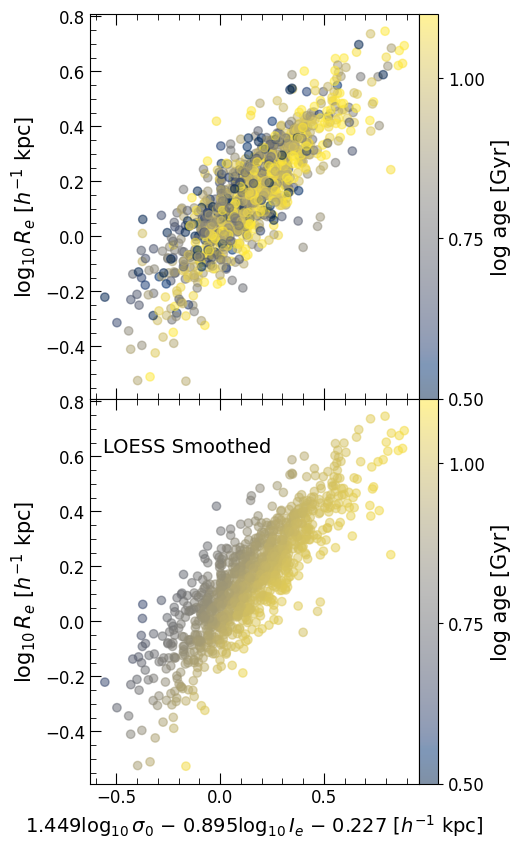

In [9]:
# Load FP fits
fp_fits = pd.read_csv("../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv", index_col=0).loc["ALL_COMBINED"]
fp_fits["c"] = fp_fits["rmean"] - fp_fits["a"] * fp_fits["smean"] - fp_fits["b"] * fp_fits["imean"]
a = np.round(fp_fits["a"], 3)
b = np.round(fp_fits["b"], 3)
c = np.round(fp_fits["c"], 3)

CMAP = "cividis"

# Load FP fits (LAMOST FP and combined FP)
fp_fits_lamost = pd.read_csv("../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv", index_col=0).loc["LAMOST"]
fp_fits_lamost["c"] = fp_fits_lamost["rmean"] - fp_fits_lamost["a"] * fp_fits_lamost["smean"] - fp_fits_lamost["b"] * fp_fits_lamost["imean"]
fp_fits_all_combined = pd.read_csv("../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv", index_col=0).loc["ALL_COMBINED"]
fp_fits_all_combined["c"] = fp_fits_all_combined["rmean"] - fp_fits_all_combined["a"] * fp_fits_all_combined["smean"] - fp_fits_all_combined["b"] * fp_fits_all_combined["imean"]

# Load LAMOST data and calculate residual
df = pd.read_csv("../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_0/lamost.csv")
df["r_fp_lamost"] = fp_fits_lamost["a"] * df["s"] + fp_fits_lamost["b"] * df["i"] + fp_fits_lamost["c"]
df["r_fp"] = fp_fits_all_combined["a"] * df["s"] + fp_fits_all_combined["b"] * df["i"] + fp_fits_all_combined["c"]
# df["residual_lamost"] = df["r"] - df["r_fp_lamost"]
# df["residual_all_combined"] = df["r"] - df["r_fp_all_combined"]

# Load stellar ages from external data
columns = ["obsid", "ra", "dec", "z", "SNr", "r_p", "log_Age", "metallicity"]
df_ages = pd.read_csv("../data/external/lamost_ages/table1.dat", delim_whitespace=True, names=columns)
df_ages["obsid"] = df_ages["obsid"].apply(lambda x: "LAMOST" + str(x))
df_ages["log_Age"] -= 9.0
# df_ages = df_ages[(df_ages["log_Age"] > 9.0) & (df_ages["log_Age"] < 10.2)]

# Merge based on obsid
df = pd.merge(df[["obsid", "r", "s", "i", "r_fp"]], df_ages, on="obsid")
# df.to_csv("../scrap/lamost_age.csv", index=False)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(FIGURE_WIDTH // 2 + 1, FIGURE_HEIGHT * 2), sharex=True, gridspec_kw={'hspace': 0})

# Ax1 (Raw)
scatter = ax1.scatter(df["r_fp"], df["r"], c=df["log_Age"], cmap=CMAP, vmin=0.5, vmax=1.1, alpha=0.5)
cbar = fig.colorbar(scatter, ax=ax1, pad=0.0)
cbar.set_label(label=r'log age [Gyr]', fontsize=15)
ax1.set_ylabel(f'{r_label} [{r_unit}]', fontsize=15)
cbar.set_ticks([0.5, 0.75, 1.0])

# Ax2 (LOESS Smoothed)
x = df["r_fp"].to_numpy()
y = df["r"].to_numpy()
z = df["log_Age"].to_numpy()

zout, wout = loess_2d(x, y, z, xnew=None, ynew=None, degree=1, frac=0.8,
                      npoints=None, rescale=False, sigz=None)
scatter = ax2.scatter(x, y, c=zout, cmap=CMAP, vmin=0.5, vmax=1.1, alpha=0.5)
cbar = fig.colorbar(scatter, ax=ax2, pad=0.0)
cbar.set_label(label=r'log age [Gyr]', fontsize=15)
ax2.text(0.04, 0.9, "LOESS Smoothed", transform=ax2.transAxes, fontsize=14, 
         verticalalignment='top', horizontalalignment='left')
ax2.set_ylabel(f'{r_label} [{r_unit}]', fontsize=15)
ax2.set_xlabel(rf'{a}{s_label} $-$ {np.absolute(b)}{i_label} $-$ {np.absolute(c)} [{r_unit}]', fontsize=14)

for i, ax in enumerate(fig.axes):
    ax.tick_params(axis='both', which='major', labelsize=12)

cbar.set_ticks([0.5, 0.75, 1.0])

for ax in fig.axes[:2]:
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)
    ax.minorticks_on()
# fig.savefig('../img/final_plot/fig_9_lamost_fp_vs_age.pdf', bbox_inches='tight', dpi=300)

# Fig 10. Logdist Worst PDFs and Distributions

6dFGS | [6118, 6200]
LAMOST | [1488, 1644]


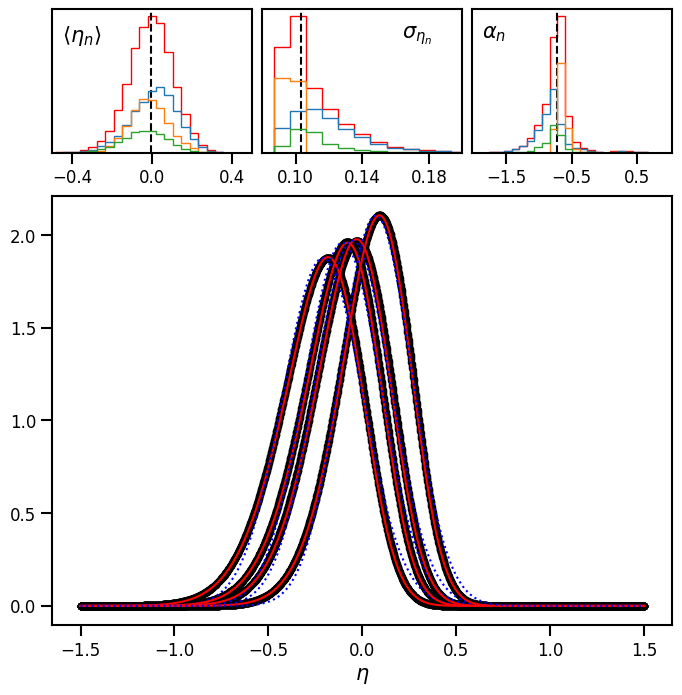

In [7]:
mpl.rcParams['axes.linewidth'] = 1.5

def skew_normal(x, loc, scale, alpha):
    def std_normal(x):
        return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    
    def cdf(x):
        return 0.5 * (1 + erf(x / np.sqrt(2)))
    
    return (2 / scale) * std_normal((x - loc) / scale) * cdf(alpha * (x - loc) / scale) * 0.988

fp_fit = "ALL_COMBINED"
fp_fit_method = 0

# Candidate log-distance ratios
dmin, dmax, nd = -1.5, 1.5, 2001
dbins = np.linspace(dmin, dmax, nd, endpoint=True)

# Differentiate 3 survey colors
colors = ["C0", "C1", "C2"]

# Create a figure
a_ = 8
fig = plt.figure(figsize=(a_ , a_ ))
NBINS = 25

# Create a GridSpec with 2 rows and 3 columns
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 3], wspace=0.05, hspace=0.15)

# First axis: edge-on FP (r_obs vs r_pred)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Axis 2, 3, 4: bivariate distributions (r vs i, r vs s, i vs s)
ax4 = fig.add_subplot(gs[1, :])


# Histograms of logdist parameters
df_combined = pd.DataFrame()
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}.csv")
    df_combined = pd.concat([df_combined, df], axis=0)

logdist_mean_bins = np.linspace(df_combined["logdist_mean_all_combined"].min(), df_combined["logdist_mean_all_combined"].max(), NBINS)
logdist_scale_bins = np.linspace(df_combined["logdist_scale_all_combined"].min(), df_combined["logdist_scale_all_combined"].max(), NBINS)
logdist_alpha_bins = np.linspace(df_combined["logdist_alpha_all_combined"].min(), df_combined["logdist_alpha_all_combined"].max(), NBINS)
ax1.hist(df_combined["logdist_all_combined"], bins=logdist_mean_bins, histtype="step", color='r')
ax2.hist(df_combined["logdist_err_all_combined"], bins=logdist_scale_bins, histtype="step", color='r')
ax3.hist(df_combined["logdist_alpha_all_combined"], bins=logdist_alpha_bins, histtype="step", color='r')
ax1.axvline(df_combined["logdist_all_combined"].quantile(0.5), c='k', ls="--")
ax2.axvline(df_combined["logdist_err_all_combined"].quantile(0.5), c='k', ls="--")
ax3.axvline(df_combined["logdist_alpha_all_combined"].quantile(0.5), c='k', ls="--")


for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}.csv")
    ax1.hist(df["logdist_all_combined"], bins=logdist_mean_bins, histtype="step")
    ax2.hist(df["logdist_err_all_combined"], bins=logdist_scale_bins, histtype="step")
    ax3.hist(df["logdist_alpha_all_combined"], bins=logdist_alpha_bins, histtype="step")
    df_combined = pd.concat([df_combined, df], axis=0)

# Ax4: worst posteriod PDFs
for i, survey in enumerate(["6dFGS", "LAMOST"]):
    # Load posterior pdf
    posterior_pdfs = np.load(f"../artifacts/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}_posterior_{fp_fit.lower()}_fp.npy")

    # Load worst PDFs
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}.csv")
    df_worst = df[df[f"logdist_alpha_{fp_fit.lower()}"] < -1.4]
    df_worst = df_worst.sort_values(by=f'logdist_rmse_{fp_fit.lower()}', ascending=False).head(2)
    worst_index = list(df_worst.index)
    print(f"{survey} | {worst_index}")
    logdist = df_worst[f"logdist_{fp_fit.lower()}"].tolist()
    logdist_err = df_worst[f"logdist_err_{fp_fit.lower()}"].tolist()
    loc_ = df_worst[f"logdist_loc_{fp_fit.lower()}"].tolist()
    scale_ = df_worst[f"logdist_scale_{fp_fit.lower()}"].tolist()
    alpha_ = df_worst[f"logdist_alpha_{fp_fit.lower()}"].tolist()

    for j, idx in enumerate(worst_index):
        # ax4.axvline(x=logdist[j])
        ax4.plot(dbins, skew_normal(dbins, loc=loc_[j], scale=scale_[j], alpha=alpha_[j]), c='r')
        ax4.plot(dbins, norm.pdf(dbins, loc=logdist[j], scale=logdist_err[j]), c='blue', ls=":")
        y = posterior_pdfs[idx]
        ax4.scatter(dbins, y, s=20, c='k')

# Remove y labels for histograms
labels_ = [r"$\langle \eta_n \rangle$", r"$\sigma_{\eta_n}$", r"$\alpha_n$"]
for i, ax in enumerate([ax1, ax2, ax3]):
    xloc = 0.05
    if i == 1:
        xloc = 0.7
    ax.set_yticks([])
    ax.tick_params(left=False)
    ax.text(xloc, 0.90, labels_[i], transform=ax.transAxes, fontsize=15, 
         verticalalignment='top', horizontalalignment='left')
ax4.set_xlabel(r"$\eta$", fontsize=15)

for i, ax in enumerate(fig.axes):
    ax.tick_params(axis='both', which='major', labelsize=12)

# Custom plot configs
ax1.set_xlim(-0.5, 0.5)
ax1.set_xticks([-0.4, 0, 0.4])

ax2.set_xlim(0.08, 0.2)
ax2.set_xticks([0.1, 0.14, 0.18])

ax3.set_xticks([-1.5, -0.5, 0.5,])

for ax in fig.axes:
    ax.tick_params(axis='both', which='major', length=8, width=1.5)

# fig.savefig('../img/final_plot/fig_10_logdist_distributions.pdf', bbox_inches='tight', dpi=300)

# Fig 11. Internal Consistency Checks
## 11a. Logdist from combined FP

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 15
Rejected comparison in ('6dFGS', 'LAMOST'): 3


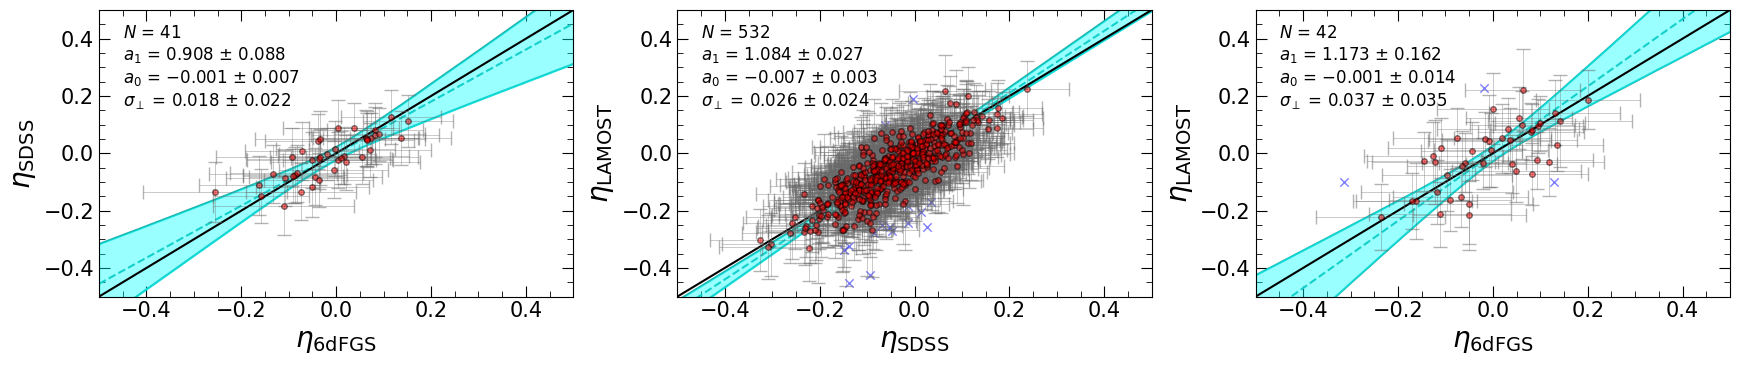

In [7]:
fp_fit = "ALL_COMBINED"

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df["chisq"] = np.absolute(df["logdist_all_combined_x"] - df["logdist_all_combined_y"]) / np.sqrt(df["logdist_err_all_combined_x"]**2 + df["logdist_err_all_combined_y"]**2)
    df_rejects = df[df["chisq"] > 1.0]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df["chisq"] <= 1.]

    ndata = len(df)
    x = df[f"logdist_{fp_fit.lower()}_x"].to_numpy()
    xerr = df[f"logdist_err_{fp_fit.lower()}_x"].to_numpy()
    y = df[f"logdist_{fp_fit.lower()}_y"].to_numpy()
    yerr = df[f"logdist_err_{fp_fit.lower()}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects["logdist_all_combined_x"], df_rejects["logdist_all_combined_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
fig.savefig('../img/final_plot/fig_11a_internal_consistency_checks_combined_fp.pdf', bbox_inches='tight', dpi=300)

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 16
Rejected comparison in ('6dFGS', 'LAMOST'): 8


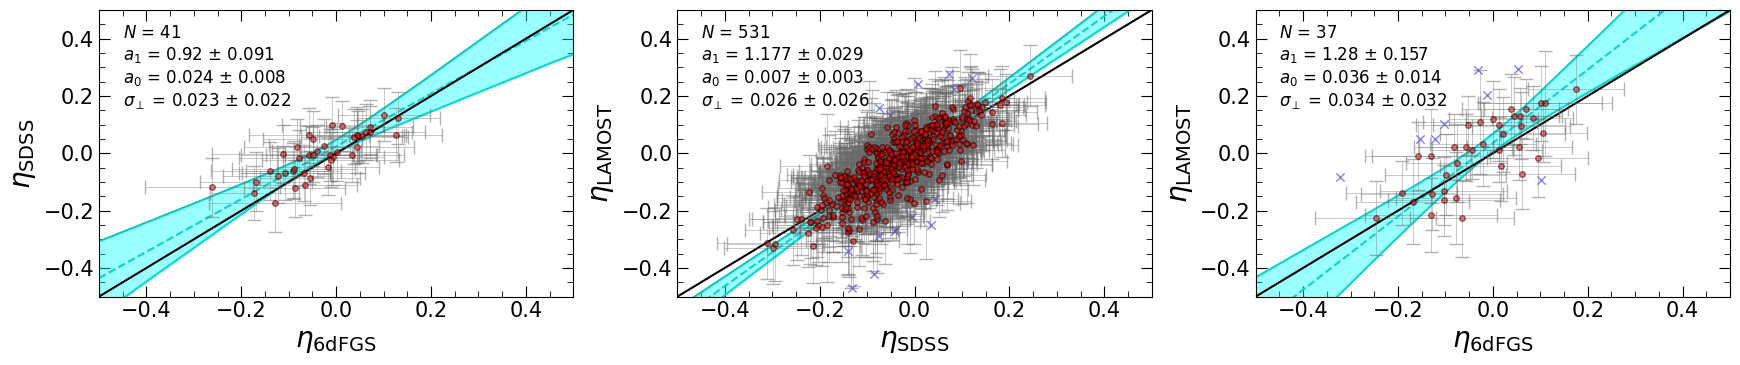

In [10]:
fp_fit = "ALL_COMBINED"

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df["chisq"] = np.absolute(df[f"logdist_{survey1.lower()}_x"] - df[f"logdist_{survey2.lower()}_y"]) / np.sqrt(df[f"logdist_err_{survey1.lower()}_x"]**2 + df[f"logdist_err_{survey2.lower()}_y"]**2)
    df_rejects = df[df["chisq"] > 1.0]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df["chisq"] <= 1.]

    ndata = len(df)
    x = df[f"logdist_{survey1.lower()}_x"].to_numpy()
    xerr = df[f"logdist_err_{survey1.lower()}_x"].to_numpy()
    y = df[f"logdist_{survey2.lower()}_y"].to_numpy()
    yerr = df[f"logdist_err_{survey2.lower()}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{survey1.lower()}_x"], df_rejects[f"logdist_{survey2.lower()}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
fig.savefig('../img/final_plot/fig_11b_internal_consistency_checks_each_fp.pdf', bbox_inches='tight', dpi=300)

# Fig 12. Logdist vs Redshift

(-0.5, 0.5)

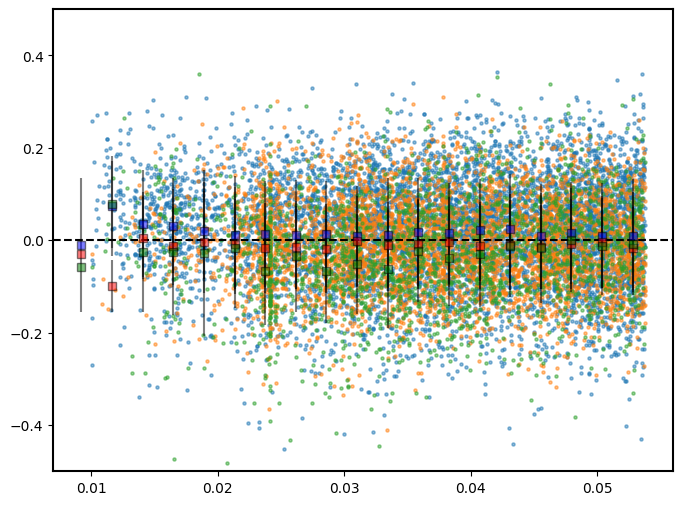

In [128]:
mpl.rcParams['axes.linewidth'] = 1.5

fp_fit = "ALL_COMBINED"
fp_fit_method = 0

z_bins = np.linspace(0.008, 0.054, 20)
z_bins_labels = range(1, len(z_bins))
survey_colors = ["b", "r", "g"]

fig, ax = plt.subplots(figsize=(8, 6))
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    # Load worst PDFs
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}.csv")
    df[f"logdist_{fp_fit.lower()}"] += 0.008
    logdist = df[f"logdist_{fp_fit.lower()}"].to_numpy()
    logdist_err = df[f"logdist_err_{fp_fit.lower()}"].to_numpy()
    
    ax.scatter(df["z_dist_est"], logdist, s=5, alpha=0.5)

    # Binned vs redshift
    df['z_bin'] = pd.cut(df['z_dist_est'], z_bins, labels=z_bins_labels)
    z_bins_middle = 0.5 * (z_bins[1:] + z_bins[:-1])
    logdist_binned_mean = df[['z_bin', f'logdist_{fp_fit.lower()}']].groupby(by='z_bin', observed=False).mean().values.ravel()
    logdist_binned_std = df[['z_bin', f'logdist_{fp_fit.lower()}']].groupby(by='z_bin', observed=False).std().to_numpy().ravel()
    ax.errorbar(z_bins_middle, logdist_binned_mean, yerr=logdist_binned_std, fmt='s', mec='k', mfc=survey_colors[i], ecolor='k', alpha=0.5)

ax.axhline(y=0, c='k', ls="--")
ax.set_ylim(-0.5, 0.5)

In [82]:
df["z_dist_est"].max()

0.05377